# Test Method

In [23]:
# Song Liu (song.liu@bristol.ac.uk), 01-06-2023
# All rights reserved.

# load csv files from archive folder
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm 
from copy import deepcopy


def torch_normcdf(x: torch.Tensor) -> torch.Tensor:
    return 0.5 * (1 + torch.erf(x / (2**0.5)))


# Regulariser Framework 
class GenReg(ABC, nn.Module): 
    def __init__(self, loss = nn.L1Loss(), regtype:str='fp'):
        super().__init__()
        self.loss = loss    
        if regtype == 'fp':
            self.test_labs = [0]
        elif regtype == 'tp':
            self.test_labs = [1]
        elif regtype == 'both':
            self.test_labs = [0, 1]
        else:
            raise ValueError('type should be one of fp, tp, both')
        self.regtype = regtype.lower()
    
    @abstractmethod
    def subgroup_reg(self, scores_1:Tensor, scores_2:Tensor):
        pass
    
    def forward(self, labels, scores, group_data, **kwargs):
        groups = torch.unique(group_data)
        loss = 0
        # Iterate over true label types
        for test_label in self.test_labs:
            # Iterate over protected groups
            for group in groups:
                label_score = scores[labels==test_label]
                labelgroup_score = scores[(group_data==group) & (labels==test_label)]
                loss += self.subgroup_reg(labelgroup_score, label_score, test_label, **kwargs)
        
        return loss


class KDEReg(GenReg):
    a = 0.4920
    b = 0.2887
    c = 1.1893
    
    @staticmethod
    def F_est(y: Tensor)->Tensor:
        return torch.exp(-KDEReg.a*y**2 - KDEReg.b*y - KDEReg.c)
    
    def __init__(self, h: int, casttoprob=False, loss = nn.L1Loss(), regtype: str= 'fp' ):
        super().__init__(loss, regtype)
        self.h = h
        self.casttoprob=casttoprob
    
    def subgroup_reg(self, scores_1:Tensor, scores_2:Tensor, test_label: int, tau: int):
        # Cast onto [0,1] if necessary
        if self.casttoprob:
            scores_1 = torch.sigmoid(scores_1)
            scores_2 = torch.sigmoid(scores_2)
        # Caclaulte kernel CDF estimates
        kernel_1 = torch.mean(self.F_est((tau-scores_1)/self.h))
        kernel_2 = torch.mean(self.F_est((tau-scores_2)/self.h))
        return self.loss(kernel_1, kernel_2)


class KDERegExact(KDEReg):
    @staticmethod
    def F_est(y: Tensor)->Tensor:
        return 1-torch_normcdf(y)
    

class FDRRegExact(ABC, nn.Module):
    def __init__(self, h: int, prior: float = None, prior_groups: list[float] = None,
                 casttoprob=False, loss = nn.L1Loss()):
        super().__init__()
        self.loss = loss
        self.h = h
        self.casttoprob=casttoprob
        self.prior = prior
        self.prior_groups = prior_groups
        if self.prior is None or self.prior_groups is None:
            self.calculate_prior = True

    @staticmethod
    def F_est(y: Tensor)->Tensor:
        return 1-torch_normcdf(y)

    def forward(self, labels, scores, group_data, **kwargs):
        groups = torch.unique(group_data)
        if self.calculate_prior:
            # Claculate priors from data
            self.prior = torch.mean(labels)
            self.prior_groups = []
            for group in groups:
                self.prior_groups.append(torch.mean(labels[group_data==group]))
        loss = 0
    
        # Iterate over protected groups
        for group, prior_group in zip(groups, self.prior_groups):
            scores0_group = scores[(group_data==group) & (labels==0.)]
            scores1_group = scores[(group_data==group) & (labels==1.)]
            scores0 = scores[labels==0.]
            scores1 = scores[labels==1.]
            loss += self.subgroup_reg(scores0, scores1, scores0_group, scores1_group, self.prior, prior_group, **kwargs)
        return loss
    
    def subgroup_reg(self, scores0: Tensor, scores1: Tensor, scores0_group:Tensor,
                     scores1_group: Tensor, prior: float, prior_group: float, tau: int):
        # Cast onto [0,1] if necessary
        if self.casttoprob:
            scores0 = torch.sigmoid(scores0)
            scores1 = torch.sigmoid(scores1)
            scores0_group = torch.sigmoid(scores0_group)
            scores1_group = torch.sigmoid(scores1_group)
        # Caclaulte kernel CDF estimates
        kernel0 = torch.mean(self.F_est((tau-scores0)/self.h))
        kernel1 = torch.mean(self.F_est((tau-scores1)/self.h))
        kernel0_group = torch.mean(self.F_est((tau-scores0_group)/self.h))
        kernel1_group = torch.mean(self.F_est((tau-scores1_group)/self.h))
        fdr_gen = (1-prior)*kernel0/(prior*kernel1+(1-prior)*kernel0)
        fdr_group = (1-prior_group)*kernel0_group/(prior_group*kernel1_group+(1-prior_group)*kernel0_group)
        return self.loss(fdr_gen, fdr_group)

class FDRRegPW(FDRRegExact):
    def __init__(self, h: int, prior: float, prior_groups: list[float],
                 casttoprob=False, loss = nn.L1Loss()):
        super().__init__(h, prior, prior_groups, casttoprob, loss)
        # Force priors to be specified and NOT calculated from data
        self.calculate_prior = False

    def forward(self, scores0, scores1, group_data0, group_data1, **kwargs):
        groups = torch.unique(torch.cat((group_data0,group_data1)))
        loss = 0
        # Iterate over protected groups
        for group, prior_group in zip(groups, self.prior_groups):
            scores0_group = scores0[group_data0==group]
            scores1_group = scores1[group_data1==group]
            loss += self.subgroup_reg(scores0, scores1, scores0_group, scores1_group, self.prior, prior_group, **kwargs)
        return loss

class PWKDEReg(KDEReg): 
    # Re-define forward method to account for already separated scores  
    def forward(self, scores0, scores1, group_data0, group_data1, **kwargs):
        # Get data groups
        groups = torch.unique(torch.cat((group_data0, group_data1)))
        # Combine scores
        scores = {"0": scores0, "1": scores1}
        group_data = {"0": group_data0, "1": group_data1} 
        loss = 0
        # Iterate over true label types
        for test_label in self.test_labs:
            label_key = str(test_label)
            # Iterate over protected groups
            for group in groups:
                label_score = scores[label_key]
                labelgroup_score = scores[label_key][group_data[label_key]==group]
                loss += self.subgroup_reg(labelgroup_score, label_score, test_label, **kwargs)
        return loss
    
class PWKDERegExact(PWKDEReg):
    @staticmethod
    def F_est(y: Tensor)->Tensor:
        return KDERegExact.F_est(y)


class BCEReg(GenReg):
    def __init__(self, logit=False, loss = nn.L1Loss(), regtype:str='fp'):
        super().__init__(loss, regtype)
        if logit:
            self.regloss = F.binary_cross_entropy_with_logits
        else:
            self.regloss = F.binary_cross_entropy
    def subgroup_reg(self, scores_1: Tensor, scores_2: Tensor, test_label:int):
        bce_1 = self.regloss(scores_1, torch.ones_like(scores_1)*test_label)
        bce_2 = self.regloss(scores_2, torch.ones_like(scores_2)*test_label)
        return self.loss(bce_1, bce_2)


class PWBCEReg(BCEReg): 
    # Re-define forward method to account for already separated scores  
    def forward(self, scores0, scores1, group_data0, group_data1):
        return PWKDEReg.forward(self, scores0, scores1, group_data0, group_data1)


def equality_loss(labels, preds, group_data, regtype: str =  "fp", logit = False):
    groups = torch.unique(group_data)
    if regtype == 'fp':
        test_labs = [0]
    elif regtype == 'tp':
        test_labs = [1]
    elif regtype == 'both':
        test_labs = [0, 1]
     
    loss = 0
    if regtype in ['fp', 'tp', 'both']:
        # Iterate over true label types
        for test_label in test_labs:
            # Iterate over protected groups
            for group in groups:
                label_preds = preds[labels==test_label]
                grouplabel_preds = preds[(group_data==group) & (labels==test_label)]
                prob_gen = torch.mean(label_preds)
                prob_group = torch.mean(grouplabel_preds)
                if logit:
                    prob_gen = torch.logit(prob_gen)
                    prob_group = torch.logit(prob_group)
                loss += torch.abs(prob_gen-prob_group)
    elif regtype == "fdr":
        for group in groups:
            labels_pred1 = labels[preds==1]
            labels_pred1_group = labels[(group_data==group) & (preds==1)]
            prob_gen = torch.mean(1-labels_pred1)
            prob_group = torch.mean(1-labels_pred1_group)
            if logit:
                prob_gen = torch.logit(prob_gen)
                prob_group = torch.logit(prob_group)
            loss += torch.abs(prob_gen-prob_group)
    return loss


def equality_loss_pw(preds0, preds1, group_data0, group_data1, regtype: str =  "fp", prior=None, prior_groups=None, logit=False):
    groups = torch.unique(torch.cat((group_data0, group_data1)))
    if regtype == 'fp':
        test_labs = [0]
    elif regtype == 'tp':
        test_labs = [1]
    elif regtype == 'both':
        test_labs = [0, 1]

    preds = {"0": preds0, "1": preds1}
    group_data = {"0": group_data0, "1": group_data1}
     
    loss = 0
    if regtype in ['fp', 'tp', 'both']:
        # Iterate over true label types
        for test_label in test_labs:
            str_lab = str(test_label)
            # Iterate over protected groups
            for group in groups:
                label_preds = preds[str_lab]
                grouplabel_preds = preds[str_lab][group_data[str_lab]==group]
                prob_gen = torch.mean(label_preds)
                prob_group = torch.mean(grouplabel_preds)
                if logit:
                    prob_gen = torch.logit(prob_gen)
                    prob_group = torch.logit(prob_group)
                loss += torch.abs(prob_gen-prob_group)
    elif regtype == "fdr":
        if prior is None or prior_groups is None:
            raise ValueError("Prior and prior groups must be specified for FDR")
        for group, prior_group in zip(groups, prior_groups):
            fdr_gen = (1-prior)*torch.mean(preds0)/(prior*torch.mean(preds1)+(1-prior)*torch.mean(preds0))
            fdr_group = ((1-prior_group)*torch.mean(preds0[group_data0==group])
                            / (prior_group*torch.mean(preds1[group_data1==group])
                                + (1-prior_group)*torch.mean(preds0[group_data0==group])))
            if logit:
                fdr_gen = torch.logit(fdr_gen)
                fdr_group = torch.logit(fdr_group)
            loss += torch.abs(fdr_gen-fdr_group)
    return loss
    

class Classifier(nn.Module):
    def __init__(self, score_model, tau: int = 0.5, casttoprob: bool = False):
        super().__init__()
        self.score_model = score_model
        self.tau: Tensor
        self.register_buffer('tau', torch.tensor(tau))
        self.casttoprob = casttoprob

    def forward(self, x):
        x = self.score_model(x)
        return x
    def predict(self, x):
        x = self.forward(x)
        if self.casttoprob:
            x = torch.sigmoid(x)
        return (x > self.tau).float()
    

def update_tau(classifier: Classifier, scores0: Tensor, scores1: Tensor, type="fp", value=0.1, prior=None):
    if type == "fp":
        classifier.tau = torch.quantile(scores0, 1-value)
    elif type == "tp":
        classifier.tau = torch.quantile(scores1, 1-value)
    elif type in ["fdr", "prop1"]:
        if prior is not None:
            # Adjust scores to give true prior if necessary
            n0, n1 = scores0.shape[0], scores1.shape[0]
            current_prior = n1/(n1+n0)
            if current_prior < prior:
                rep_count = int(n0*prior/(1-prior))
                scores1 = scores1[torch.randint(0, n1, (rep_count,)).long()]
            else:
                rep_count = int(n1*(1-prior)/prior)
                scores0 = scores0[torch.randint(0, n0, (rep_count,)).long()]
        
        # Get scores and labels
        scores = torch.cat((scores0, scores1))
        labels = torch.cat((torch.zeros_like(scores0), torch.ones_like(scores1)))
        if type == "fdr":
            quant = 1-fdr_score_prop1(scores, labels, value)
            classifier.tau = torch.quantile(scores,quant)
        elif type == "prop1":
            classifier.tau = torch.quantile(scores, 1-value)
    else:
        raise ValueError("type should be one of fp, tp")
def fdr_score_prop1(scores,labels, value):
    # Sort both
    scores, indices = torch.sort(scores, descending=True)
    labels = labels[indices]
    fdrs = (torch.cumsum(1-labels, dim=0))/torch.arange(1, scores.shape[0]+1)
    quantile = torch.max(torch.nonzero(fdrs < value))/scores.shape[0]
    return quantile


ROC space is $[0,1]^2$, where the x axis is False Positive Rate (FPR) and y axis is True Positive Rate (TPR).

Recall, $\mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$ and $\mathrm{FPR} = \frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}}$.

In [3]:
base = pd.read_csv('../../archive/Variant I.csv')
# remove 'income', 'customer_age', 'employment_status' columns as they are protected
sensitive = base[['income', 'customer_age', 'employment_status']]
# Get filter for our employment groups
employment_status = base['employment_status'].astype("category").cat.codes
employment_filter = base['employment_status'].isin(['CA', 'CB'])
base = base.drop(columns=['income', 'customer_age', 'employment_status'])
# convert categorical variables in 'payment_type' to integers
base['payment_type'] = base['payment_type'].astype('category')
base['housing_status'] = base['housing_status'].astype('category')
base['source'] = base['source'].astype('category')
base['device_os'] = base['device_os'].astype('category')

cat_columns = base.select_dtypes(['category']).columns
base[cat_columns] = base[cat_columns].apply(lambda x: x.cat.codes)

base_pd = base

missing_value = -10 # missing values are replaced by this!

def mean_std_scale(x): return (x - x.mean())/x.std()

df = pd.DataFrame(index=range(len(base)), columns=[])
df['fraud_bool'] = base['fraud_bool'].copy().astype(float)
df['name_email_similarity'] = base['name_email_similarity'].copy()

## scale
prev = base['prev_address_months_count'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['prev_address_months_count'] = prev.copy()

prev = base['current_address_months_count'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['current_address_months_count'] = prev.copy()

df['days_since_request'] = mean_std_scale(base['days_since_request']).copy()
df['intended_balcon_amount'] = mean_std_scale(base['intended_balcon_amount']).copy()

pt = pd.get_dummies(base, columns=['payment_type'])
for i in range(5): df[f'payment_type_{i}'] = pt[f'payment_type_{i}'].astype(float)


df['zip_count_4w'] = mean_std_scale(base['zip_count_4w'].copy().astype(float))

## not sure these should be mean/std scaled tbh... maybe min/max scaling would be better
## https://www.dropbox.com/scl/fo/vg4b2hyapa9o9ajanbfl3/AL1RUfD1rAb5RBvgFQwc8eI/bank-account-fraud/documents?dl=0&preview=datasheet.pdf&rlkey=2r99po055q5pjbg1934ga0c8i&subfolder_nav_tracking=1
for col in ['velocity_6h', 'velocity_24h', 'velocity_4w',
            'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
            'credit_risk_score']:
    df[col] = mean_std_scale(base[col]).copy()

df['email_is_free'] = base['email_is_free'].copy().astype(float)


pt = pd.get_dummies(base, columns=['housing_status'])
for i in range(7): df[f'housing_status_{i}'] = pt[f'housing_status_{i}'].astype(float)

df['phone_home_valid'] = base['phone_home_valid'].copy().astype(float)
df['phone_mobile_valid'] = base['phone_mobile_valid'].copy().astype(float)


prev = base['bank_months_count'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['bank_months_count'] = prev.copy()

df['has_other_cards'] = base['has_other_cards'].copy().astype(float)
df['foreign_request'] = base['foreign_request'].copy().astype(float)


## not sure these should be mean/std scaled tbh... maybe min/max scaling would be better
## https://www.dropbox.com/scl/fo/vg4b2hyapa9o9ajanbfl3/AL1RUfD1rAb5RBvgFQwc8eI/bank-account-fraud/documents?dl=0&preview=datasheet.pdf&rlkey=2r99po055q5pjbg1934ga0c8i&subfolder_nav_tracking=1
for col in ['proposed_credit_limit']:
    df[col] = mean_std_scale(base[col]).copy()


df['source'] = base['source'].copy().astype(float)

prev = base['session_length_in_minutes'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['session_length_in_minutes'] = prev.copy()


pt = pd.get_dummies(base, columns=['device_os'])
for i in range(5): df[f'device_os_{i}'] = pt[f'device_os_{i}'].astype(float)

df['keep_alive_session'] = base['keep_alive_session'].copy().astype(float)

prev = base['device_distinct_emails_8w'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['device_distinct_emails_8w'] = prev.copy()

df['device_fraud_count'] = base['device_fraud_count'].copy().astype(float)

pt = pd.get_dummies(base, columns=['month'])
for i in range(8): df[f'month_{i}'] = pt[f'month_{i}'].astype(float)

# For now filter to only get CA and CB employment_status values
# This is for simplicity and to be removed later.
df = df[employment_filter]
employment_status = employment_status[employment_filter]
income = sensitive["income"][employment_filter]


base_torch = torch.tensor(df.to_numpy()).float()

X = base_torch[:,1:]
y = base_torch[:,0]
group = torch.tensor(employment_status.to_numpy()).float()
income_group = (torch.tensor(income.to_numpy())>.5).float()

# class prior 
prior = torch.mean(y)

print('class prior for positive:', prior)
print('class prior for negative:', 1-prior)


(X_train, X_test, y_train, y_test, group_train,
group_test, income_train, income_test) = train_test_split(X, y, group, income_group, test_size=0.1, random_state=0)

class prior for positive: tensor(0.0118)
class prior for negative: tensor(0.9882)


In [9]:
def TPR(pred, label):
    TP = torch.sum((pred==1) & (label==1))
    FN = torch.sum((pred==0) & (label==1))
    return TP/(TP+FN)

def FPR(pred, label):
    FP = torch.sum((pred==1) & (label==0))
    TN = torch.sum((pred==0) & (label==0))
    return FP/(FP+TN)

def FDR(pred, label):
    FP = torch.sum((pred==1) & (label==0))
    TP = torch.sum((pred==1) & (label==1))
    return FP/(FP+TP)

def roc(pred, label, scores_probs=False):
    # If score are probabilities, we need to convert them to scores
    if scores_probs:
        pred = torch.log(pred/(1-pred))
    fpr, tpr = [], []
    tmax = max(pred)
    tmin = min(pred)
    for t in torch.linspace(tmin, tmax, 100):
        p = pred > t
        tpr.append(TPR(p, label))
        fpr.append(FPR(p, label))
    return fpr, tpr

def AUC(fpr, tpr):
    return sum([(tpr[i]+tpr[i-1])*(fpr[i-1]-fpr[i])/2 for i in range(1, len(fpr))])    

def aucloss(pred, label):
    if pred[label==1].shape[0] == 0: # you might end up with no positive samples
        print('no positive samples!')
    pos_pred = pred[label==1]
    neg_pred = pred[label==0]
    
    # hinge loss
    T = (neg_pred.T - pos_pred)
    loss = torch.max(T, torch.zeros_like(T))/2
    loss = torch.mean(loss, dim = 0)
    loss = torch.mean(loss)
    return loss

def paired_aucloss(scores0: Tensor, scores1: Tensor):
    """Calculate the auc loss for identical length tensor of class 0 scores and class 1 scores

    Args:
        scores0 (Tensor): Scores of x values from class 0 data
        scores1 (Tensor): Scores of x values from class 1 data

    Returns:
        Tensor: AUC loss 
    """
    loss = F.relu(scores0 - scores1 + 1)
    loss = torch.mean(loss)
    return loss

# BCE Loss

Do initial run of model. We will start with logitistic regression and $\tau=0.5$.

 20%|██        | 1/5 [00:09<00:39,  9.85s/it]

Loss:  0.079, AUC:  0.521, Equality Error:  0.006


 40%|████      | 2/5 [00:20<00:31, 10.56s/it]

Loss:  0.064, AUC:  0.658, Equality Error:  0.004


 60%|██████    | 3/5 [00:31<00:21, 10.63s/it]

Loss:  0.063, AUC:  0.754, Equality Error:  0.002


 80%|████████  | 4/5 [00:42<00:10, 10.77s/it]

Loss:  0.061, AUC:  0.803, Equality Error:  0.002


100%|██████████| 5/5 [00:53<00:00, 10.62s/it]

Loss:  0.056, AUC:  0.827, Equality Error:  0.001


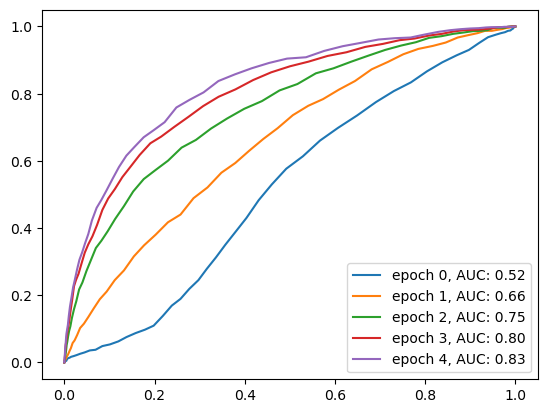

In [10]:
# Set up data
data = TensorDataset(
    X_train,
    y_train,
    group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCELoss()
tau = 0.5

model = Classifier(score_model = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid()), tau=tau, casttoprob=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss.backward()
        optimizer.step()
    pred_te = model(X_test).detach()[:,0]
    fpr, tpr = roc(pred_te, y_test, scores_probs=True)
    auc = AUC(fpr, tpr)
    equal_error  = equality_loss(y_test, pred_te, group_test, regtype='fp')
    ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    print(f"Loss: {loss.item(): 4.3f}, AUC: {auc.item(): 4.3f}, Equality Error: {equal_error.item(): 4.3f}")
ax.legend()
plt.show()


Have score as linear then take logits in loss. This should make AUC calculation better. Now also check the 

  0%|          | 0/5 [00:00<?, ?it/s]

Loss:  0.076


 20%|██        | 1/5 [00:19<01:19, 19.79s/it]

Loss:  0.076, AUC:  0.545, Equality Error:  0.000
Loss:  0.066


 40%|████      | 2/5 [00:40<01:00, 20.04s/it]

Loss:  0.066, AUC:  0.631, Equality Error:  0.000
Loss:  0.055


 60%|██████    | 3/5 [00:59<00:39, 19.91s/it]

Loss:  0.055, AUC:  0.675, Equality Error:  0.000
Loss:  0.062


 80%|████████  | 4/5 [01:20<00:20, 20.18s/it]

Loss:  0.062, AUC:  0.696, Equality Error:  0.000
Loss:  0.059


100%|██████████| 5/5 [01:42<00:00, 20.59s/it]

Loss:  0.059, AUC:  0.707, Equality Error:  0.000


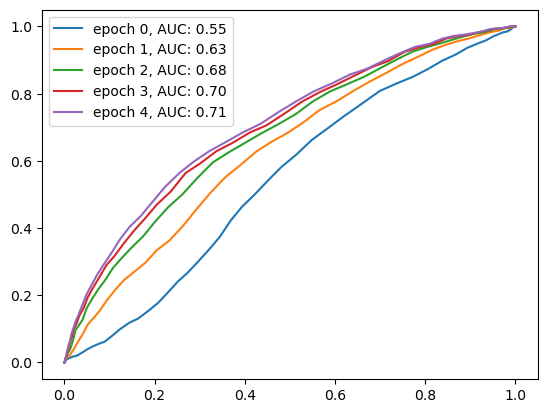

In [92]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
tau = 0.5

model = Classifier(nn.Linear(d, 1), tau=tau, casttoprob=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss.backward()
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        # Get Odd loss 
        equal_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss: {loss.item(): 4.3f}, AUC: {auc.item(): 4.3f}, Equality Error: {equal_error.item(): 4.3f}")
ax.legend()
plt.show()


## Test different $\tau$ where close FPR is less easy

### No Regularisation

tensor(0.0100)


 20%|██        | 1/5 [00:22<01:29, 22.45s/it]

Loss:  0.079, AUC:  0.560, Equality Error:  0.113


 40%|████      | 2/5 [00:42<01:03, 21.13s/it]

Loss:  0.060, AUC:  0.644, Equality Error:  0.104


 60%|██████    | 3/5 [01:03<00:42, 21.11s/it]

Loss:  0.064, AUC:  0.691, Equality Error:  0.103


 80%|████████  | 4/5 [01:23<00:20, 20.67s/it]

Loss:  0.062, AUC:  0.710, Equality Error:  0.100


100%|██████████| 5/5 [01:43<00:00, 20.77s/it]

Loss:  0.060, AUC:  0.721, Equality Error:  0.098


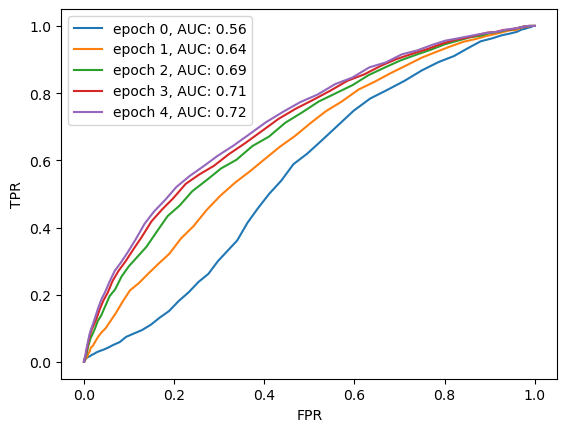

In [93]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
tau = 0.01

model = Classifier(nn.Linear(d, 1), tau=tau, casttoprob=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

print(model.tau)
fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss.backward()
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        # Get Odd loss 
        equal_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss: {loss.item(): 4.3f}, AUC: {auc: 4.3f}, Equality Error: {equal_error.item(): 4.3f}")
ax.legend()
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()


### Regularisation

 20%|██        | 1/5 [00:11<00:46, 11.68s/it]

Loss:  0.078| Reg:  0.002| AUC:  0.490| Equality Error:  0.008


 40%|████      | 2/5 [00:24<00:37, 12.51s/it]

Loss:  0.065| Reg:  0.001| AUC:  0.601| Equality Error:  0.008


 60%|██████    | 3/5 [00:37<00:25, 12.82s/it]

Loss:  0.061| Reg:  0.000| AUC:  0.653| Equality Error:  0.008


 80%|████████  | 4/5 [00:53<00:13, 13.79s/it]

Loss:  0.065| Reg:  0.004| AUC:  0.677| Equality Error:  0.008


100%|██████████| 5/5 [01:06<00:00, 13.39s/it]

Loss:  0.073| Reg:  0.002| AUC:  0.690| Equality Error:  0.008


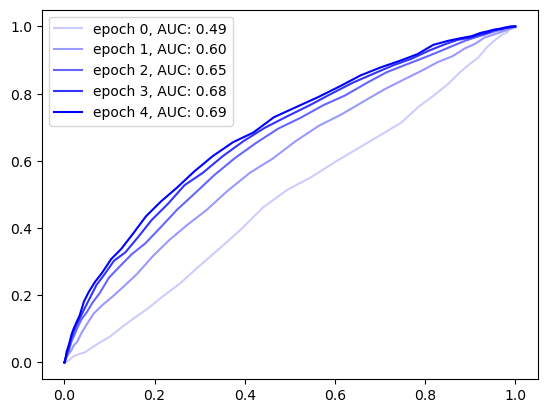

In [26]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
regularise = KDEReg(0.01, regtype='fp', casttoprob=True, loss=nn.L1Loss())


tau = 0.01
model = Classifier(nn.Linear(d, 1), tau=tau, casttoprob=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
nepochs = 5
alphas = torch.linspace(0.2, 1, nepochs)

fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(nepochs)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        reg = regularise(y, scores, group, tau=model.tau)
        loss += reg
        loss.backward()
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        # Get Odd loss 
        equality_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss: {loss.item(): 4.3f}| Reg: {reg.item(): 4.3f}| AUC: {auc: 4.3f}| Equality Error: {equal_error.item(): 4.3f}")
ax.legend()
plt.show()


### Exact Regularisation

 20%|██        | 1/5 [00:18<01:14, 18.68s/it]

Loss: 0.098 | Reg: 0.017 | Train Equality: 0.004 |  AUC: 0.440 | Equality Error: 0.020


 40%|████      | 2/5 [00:35<00:53, 17.79s/it]

Loss: 0.084 | Reg: 0.011 | Train Equality: 0.005 |  AUC: 0.478 | Equality Error: 0.020


 60%|██████    | 3/5 [00:53<00:35, 17.66s/it]

Loss: 0.074 | Reg: 0.002 | Train Equality: 0.022 |  AUC: 0.495 | Equality Error: 0.020


 80%|████████  | 4/5 [01:15<00:19, 19.38s/it]

Loss: 0.072 | Reg: 0.002 | Train Equality: 0.021 |  AUC: 0.505 | Equality Error: 0.020


100%|██████████| 5/5 [01:39<00:00, 19.84s/it]

Loss: 0.066 | Reg: 0.002 | Train Equality: 0.012 |  AUC: 0.515 | Equality Error: 0.020


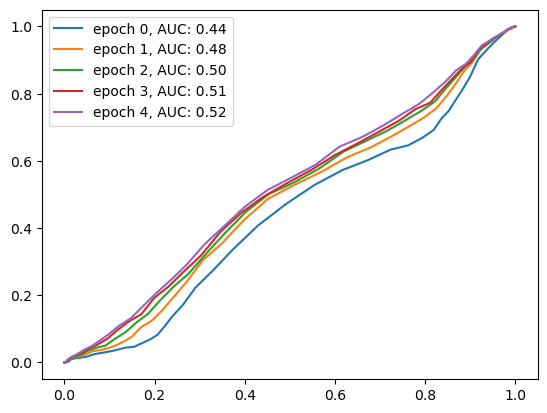

In [115]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
regularise = KDERegExact(h=0.01, regtype='fp', casttoprob=True, loss=nn.L1Loss())
tau = 0.01


model = Classifier(nn.Linear(d, 1),tau=tau, casttoprob=True)
lossfunc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        reg = regularise(y, scores, group, tau=model.tau)
        preds = model.predict(x).squeeze()
        train_equal_loss = equality_loss(y, preds, group, regtype='fp')
        loss += reg
        loss.backward()
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        # Get Odd loss 
        equality_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 1.3f} | Reg:{reg.item(): 1.3f} | Train Equality:{train_equal_loss.item(): 1.3f} | ",
              f"AUC:{auc: 1.3f} | Equality Error:{equal_error.item(): 1.3f}")
ax.legend()
plt.show()


This does give equality although there is clearly a cost

### Test Regularisation

Loss:  0.085
Reg:  0.012
Equality Error:  0.020


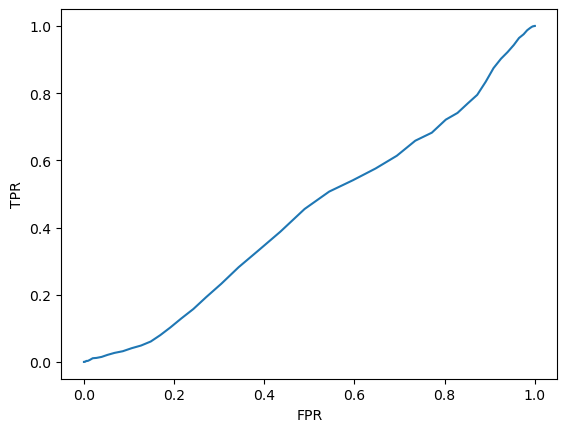

In [101]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
h=0.01
regularise = KDERegExact(h, regtype='fp', casttoprob=True, loss=nn.L1Loss())
tau = 0.01

model = Classifier(nn.Linear(d, 1), tau=tau, casttoprob=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

# Train model
for x, y, group in dataloader:
    optimizer.zero_grad()
    scores = model(x).squeeze()
    loss = lossfunc(scores, y)
    reg = regularise(y, scores, group, tau=model.tau)
    loss += reg
    loss.backward()
    optimizer.step()
scheduler.step()
print(f"Loss: {loss.item(): 4.3f}")
print(f"Reg: {reg.item(): 4.3f}")
with torch.no_grad():
    scores_te = model(X_test).squeeze()
    pred_te = model.predict(X_test).squeeze()
    # Get Odd loss 
    print(f"Equality Error: {equality_loss(y_test, pred_te, group_test, regtype='fp').item(): 4.3f}")
    fpr, tpr = roc(scores_te, y_test)
    auc = AUC(fpr, tpr)
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

In [112]:
print(model.tau)
print(equality_loss(y, model.predict(x).squeeze(), group, regtype='fp'))
temp_scores = model(x).squeeze()
print(equality_loss(y, (torch.sigmoid(temp_scores)>model.tau).float(), group, regtype='fp'))
print(equality_loss(y_test, pred_te, group_test, regtype='fp'))
print(regularise(y, scores, group, tau=model.tau))

tensor(0.0100)
tensor(0.0215)
tensor(0.0215)
tensor(0.0205)
tensor(0.0123, grad_fn=<AddBackward0>)


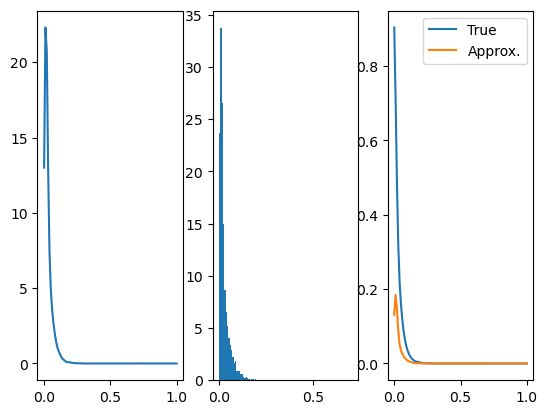

In [ ]:
# Plot kernel density of scores
scores = model(x).squeeze().detach()
scores0 = scores[y==0]
probs = torch.sigmoid(scores0)
# Plot densit on this group
def true_f_est(y: Tensor, data: Tensor, h)->Tensor:
    return (1/h)*torch.mean((1/(2*torch.pi)**0.5)*torch.exp(-0.5*((y.unsqueeze(-1)-data)/h)**2), dim=1)

def approx_f_est(y: Tensor, data: Tensor, h)->Tensor:
    return torch.mean(KDEReg.F_est((y.unsqueeze(-1)-data)/h), dim=1)

def true_F_est(y: Tensor, data: Tensor, h)->Tensor:
    norm = torch.distributions.Normal(0, h)
    return torch.mean(1-norm.cdf(y.unsqueeze(-1)-data), dim=1)

def approx_F_est(y: Tensor, data: Tensor, h)->Tensor:
    return torch.mean(KDEReg.F_est((y.unsqueeze(-1)-data)/h), dim=1)

y_vals = torch.linspace(0, 1, 100)
kde = true_f_est(y_vals, probs, h)
fig, ax = plt.subplots(ncols=3)
ax[0].plot(y_vals, kde)
ax[1].hist(probs, bins=100, density=True)
ax[2].plot(y_vals, true_F_est(y_vals, probs, h), label="True")
ax[2].plot(y_vals, approx_F_est(y_vals, probs, h), label="Approx.")
ax[2].legend() 

Here it is clear that the approximation given in the function is a poor one. We can use the exact normal cdf using the ERF function which actually isn't even slower.

## Multiple Experiments

In [116]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
regularise = KDERegExact(0.01, regtype='fp', casttoprob=True)
tau = 0.01

equal_losses = []
aucs = []
rocs = []
lambs = [0.,0.25,0.5,0.75,1.]
nrep = 3
for lamb in tqdm(lambs):
    for j in range(nrep):
        # Set-up model
        model = Classifier(nn.Linear(d, 1), tau=tau, casttoprob=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        # Train model
        for epoch in range(5):
            for x, y, group in dataloader:
                optimizer.zero_grad()
                scores = model(x).squeeze()
                loss = lossfunc(scores, y)
                loss += lamb*regularise(y, scores, group, tau=model.tau)
                loss.backward()
                optimizer.step()
            scheduler.step()
            
        with torch.no_grad():
            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            # Get Odd loss 
            equal_loss = equality_loss(y_test, pred_te, group_test, regtype='fp').item()
            equal_losses.append(equal_loss)
            fpr, tpr = roc(scores_te, y_test)
            rocs.append([fpr, tpr])
            auc = AUC(fpr, tpr)
            aucs.append(auc)

100%|██████████| 5/5 [20:06<00:00, 241.37s/it]


In [117]:

# dim 0: lambda, dim 1: run
equal_losses = torch.tensor(equal_losses)
equal_losses = equal_losses.reshape(len(lambs), nrep, *equal_losses[0,...].shape)
aucs = torch.tensor(aucs)
aucs = aucs.reshape(len(lambs), nrep, *aucs[0,...].shape)
# dim 2: fpr or tpr, dim 3: value 
rocs = torch.tensor(rocs)
rocs = rocs.reshape(len(lambs), nrep, *rocs[0,...].shape)

torch.save({'equal_losses': equal_losses, 'aucs': aucs, 'rocs': rocs, "lambdas": lambs},
           'BCE_results.pt')

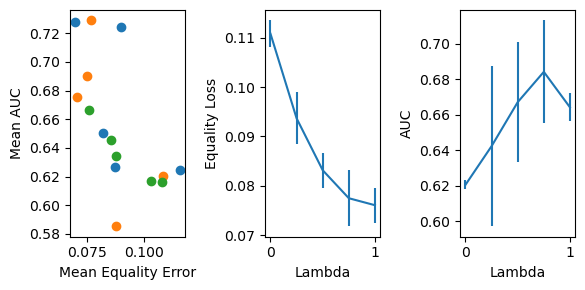

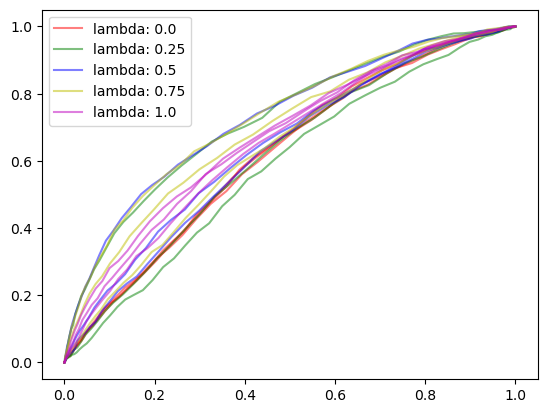

In [118]:
results = torch.load('BCE_results.pt')
equal_losses, aucs, rocs, lambs = [
    results[key] for key in ["equal_losses", "aucs", "rocs", "lambdas"]]
fig, ax = plt.subplots(ncols=3, figsize=(6,3))
ax[0].plot(equal_losses, aucs, 'o')
ax[0].set_xlabel('Mean Equality Error')
ax[0].set_ylabel('Mean AUC')
ax[1].errorbar(lambs, torch.mean(equal_losses, dim=1), yerr=1.96*torch.std(equal_losses, dim=1)/10**0.5, label = 'Mean Equal Loss')
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('Equality Loss')
ax[2].errorbar(lambs, torch.mean(aucs, dim=1), yerr=1.96*torch.std(aucs, dim=1)/10**0.5, label = 'Mean AUC')
ax[2].set_xlabel('Lambda')
ax[2].set_ylabel('AUC')
fig.tight_layout()

colours = ['r', 'g', 'b', 'y', 'm']
fig, ax = plt.subplots()
for i,lamb in enumerate(lambs):
    for j in range(aucs.shape[1]):
        if j == 0:
            ax.plot(rocs[i,j,0], rocs[i,j,1], label = f'lambda: {lamb}', color=colours[i], alpha=0.5)
        else:
            ax.plot(rocs[i,j,0], rocs[i,j,1],alpha=0.5, color=colours[i])
ax.legend()

# AUC Loss
Try with paired AUC as loss and threshold used to control FDR. Works well but equality error is v small.

 10%|█         | 1/10 [00:01<00:14,  1.57s/it]

Loss: 0.402 | Reg: 0.002 |  AUC: 0.854 | Equality Error: 0.001 |  Mean Score0: -0.689 | Var Score0: 1.746 FPR: 0.003 | TPR: 0.080 | FDR: 0.787


 20%|██        | 2/10 [00:03<00:13,  1.74s/it]

Loss: 0.400 | Reg: 0.002 |  AUC: 0.863 | Equality Error: 0.000 |  Mean Score0: -0.592 | Var Score0: 2.031 FPR: 0.002 | TPR: 0.056 | FDR: 0.701


 30%|███       | 3/10 [00:05<00:12,  1.75s/it]

Loss: 0.342 | Reg: 0.001 |  AUC: 0.865 | Equality Error: 0.000 |  Mean Score0: -0.950 | Var Score0: 1.785 FPR: 0.002 | TPR: 0.063 | FDR: 0.733


 40%|████      | 4/10 [00:06<00:10,  1.75s/it]

Loss: 0.345 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.000 |  Mean Score0: -1.033 | Var Score0: 1.684 FPR: 0.002 | TPR: 0.079 | FDR: 0.725


 50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

Loss: 0.347 | Reg: 0.002 |  AUC: 0.867 | Equality Error: 0.000 |  Mean Score0: -1.014 | Var Score0: 1.659 FPR: 0.002 | TPR: 0.071 | FDR: 0.726


 60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

Loss: 0.334 | Reg: 0.000 |  AUC: 0.867 | Equality Error: 0.000 |  Mean Score0: -0.963 | Var Score0: 1.621 FPR: 0.002 | TPR: 0.077 | FDR: 0.731


 70%|███████   | 7/10 [00:11<00:04,  1.66s/it]

Loss: 0.330 | Reg: 0.001 |  AUC: 0.867 | Equality Error: 0.000 |  Mean Score0: -0.950 | Var Score0: 1.588 FPR: 0.002 | TPR: 0.074 | FDR: 0.729


 80%|████████  | 8/10 [00:13<00:03,  1.66s/it]

Loss: 0.341 | Reg: 0.001 |  AUC: 0.867 | Equality Error: 0.000 |  Mean Score0: -0.954 | Var Score0: 1.573 FPR: 0.002 | TPR: 0.081 | FDR: 0.719


 90%|█████████ | 9/10 [00:15<00:01,  1.69s/it]

Loss: 0.351 | Reg: 0.000 |  AUC: 0.867 | Equality Error: 0.000 |  Mean Score0: -0.923 | Var Score0: 1.609 FPR: 0.002 | TPR: 0.073 | FDR: 0.731


100%|██████████| 10/10 [00:16<00:00,  1.69s/it]

Loss: 0.345 | Reg: 0.001 |  AUC: 0.867 | Equality Error: 0.000 |  Mean Score0: -0.953 | Var Score0: 1.556 FPR: 0.002 | TPR: 0.065 | FDR: 0.731


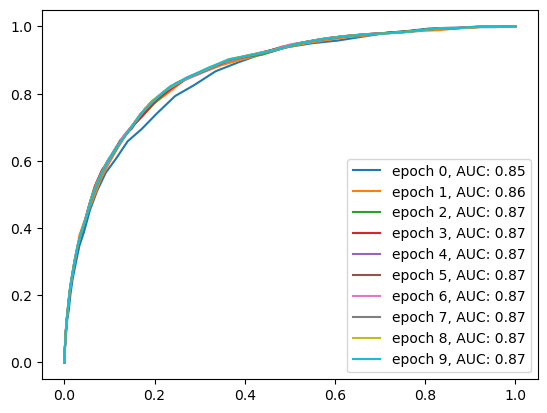

In [16]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
group_train0 = group_train[y_train==0]
group_train1 = group_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, group_train0)
data1 = TensorDataset(
    X_train1, group_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=True)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.01, regtype='fp', casttoprob=True)
mean_scores0 = []
var_scores0 = []
prop_1=0.01
fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, group0), (x1, group1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, group0, group1, tau=model.tau)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
model.tau = torch.quantile(scores0,torch.tensor([.75]))
for epoch in tqdm(range(10)):
    for (x0, group0), (x1, group1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        # loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, group0, group1, tau=model.tau)
        # upscale scores to be same length as scores0
        update_tau(model, torch.sigmoid(scores0), torch.sigmoid(scores1),
                   type="prop1", value=prop_1)
        scores1 = scores1.repeat(batch_rep)
        # Use 0 scores to update tau to give 25% FP rate
        mean_scores0.append(torch.mean(scores0))
        var_scores0.append(torch.var(scores0))
    # Get quantile to control FDR
    scores = torch.sigmoid(model(X_train).squeeze())
    prop_1 = fdr_score_prop1(scores, y_train, 0.8)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"Mean Score0: {mean_scores0[-1]: .3f} | Var Score0:{var_scores0[-1]: .3f}",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

Here the equality error is very small though this is just becasue the False Positive Rate is very low. We now see if we can avoid castying to probability space alltogether

 10%|█         | 1/10 [00:01<00:13,  1.48s/it]

Loss: 0.448 | Reg: 0.000 |  AUC: 0.846 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.064 | FDR: 0.771


 20%|██        | 2/10 [00:02<00:11,  1.48s/it]

Loss: 0.424 | Reg: 0.000 |  AUC: 0.857 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.060 | FDR: 0.701


 30%|███       | 3/10 [00:04<00:11,  1.71s/it]

Loss: 0.384 | Reg: 0.000 |  AUC: 0.865 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.065 | FDR: 0.728


 40%|████      | 4/10 [00:07<00:11,  1.87s/it]

Loss: 0.343 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.000 |  FPR: 0.003 | TPR: 0.080 | FDR: 0.744


 50%|█████     | 5/10 [00:09<00:09,  1.92s/it]

Loss: 0.348 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.001 |  FPR: 0.002 | TPR: 0.066 | FDR: 0.732


 60%|██████    | 6/10 [00:11<00:08,  2.06s/it]

Loss: 0.356 | Reg: 0.000 |  AUC: 0.867 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.074 | FDR: 0.737


 70%|███████   | 7/10 [00:13<00:06,  2.14s/it]

Loss: 0.374 | Reg: 0.000 |  AUC: 0.867 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.078 | FDR: 0.736


 80%|████████  | 8/10 [00:15<00:04,  2.10s/it]

Loss: 0.389 | Reg: 0.000 |  AUC: 0.867 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.069 | FDR: 0.736


 90%|█████████ | 9/10 [00:17<00:02,  2.15s/it]

Loss: 0.356 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.000 |  FPR: 0.003 | TPR: 0.081 | FDR: 0.740


100%|██████████| 10/10 [00:20<00:00,  2.00s/it]

Loss: 0.359 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.073 | FDR: 0.741


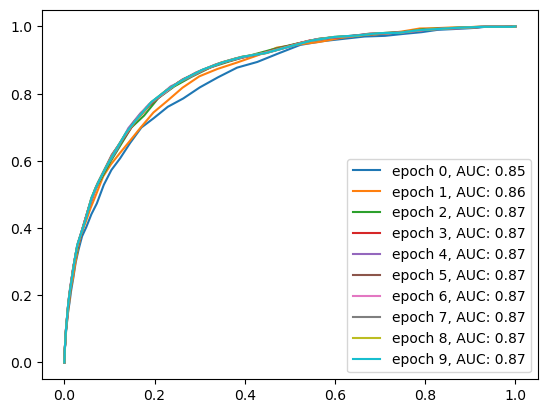

In [17]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
group_train0 = group_train[y_train==0]
group_train1 = group_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, group_train0)
data1 = TensorDataset(
    X_train1, group_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.01, regtype='fp', casttoprob=False)
mean_scores0 = []
var_scores0 = []
prop_1=0.01
fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, group0), (x1, group1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
model.tau = torch.quantile(scores0,torch.tensor([.75]))
for epoch in tqdm(range(10)):
    for (x0, group0), (x1, group1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        reg = regularise(scores0, scores1, group0, group1, tau=model.tau)
        # loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        update_tau(model, scores0, scores1,
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0 for use in paired AUC loss
        scores1 = scores1.repeat(batch_rep)
    # Get quantile to control FDR
    scores = torch.sigmoid(model(X_train).squeeze())
    prop_1 = fdr_score_prop1(scores, y_train, 0.8)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

It seems we can. Now try to test regularisation in these 2 spaces using FPR tied threshold.

 10%|█         | 1/10 [00:01<00:14,  1.61s/it]

Loss: 0.462 | Reg: 0.000 |  AUC: 0.838 | Equality Error: 0.018 |  FPR: 0.197 | TPR: 0.700 | FDR: 0.961


 20%|██        | 2/10 [00:03<00:12,  1.56s/it]

Loss: 0.399 | Reg: 0.001 |  AUC: 0.861 | Equality Error: 0.006 |  FPR: 0.198 | TPR: 0.770 | FDR: 0.957


 30%|███       | 3/10 [00:04<00:11,  1.70s/it]

Loss: 0.363 | Reg: 0.000 |  AUC: 0.865 | Equality Error: 0.001 |  FPR: 0.203 | TPR: 0.780 | FDR: 0.958


 40%|████      | 4/10 [00:06<00:10,  1.80s/it]

Loss: 0.351 | Reg: 0.000 |  AUC: 0.865 | Equality Error: 0.003 |  FPR: 0.202 | TPR: 0.781 | FDR: 0.957


 50%|█████     | 5/10 [00:08<00:09,  1.86s/it]

Loss: 0.347 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.003 |  FPR: 0.196 | TPR: 0.773 | FDR: 0.956


 60%|██████    | 6/10 [00:10<00:07,  1.87s/it]

Loss: 0.337 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.003 |  FPR: 0.202 | TPR: 0.783 | FDR: 0.957


 70%|███████   | 7/10 [00:12<00:05,  1.88s/it]

Loss: 0.369 | Reg: 0.000 |  AUC: 0.867 | Equality Error: 0.003 |  FPR: 0.202 | TPR: 0.784 | FDR: 0.957


 80%|████████  | 8/10 [00:14<00:03,  1.87s/it]

Loss: 0.386 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.002 |  FPR: 0.200 | TPR: 0.783 | FDR: 0.957


 90%|█████████ | 9/10 [00:16<00:01,  1.92s/it]

Loss: 0.350 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.002 |  FPR: 0.199 | TPR: 0.780 | FDR: 0.957


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]

Loss: 0.383 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.003 |  FPR: 0.202 | TPR: 0.784 | FDR: 0.957


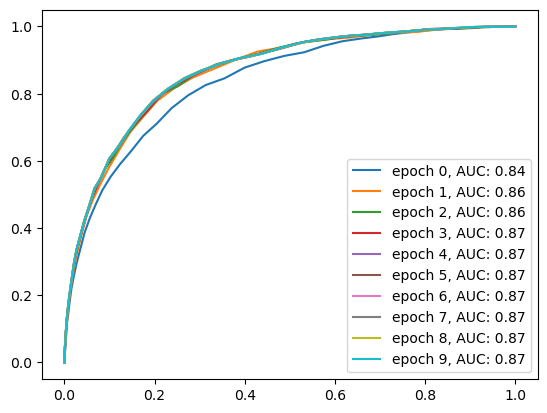

In [18]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
group_train0 = group_train[y_train==0]
group_train1 = group_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, group_train0)
data1 = TensorDataset(
    X_train1, group_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.01, regtype='fp', casttoprob=False)
prop_1=0.01
fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, group0), (x1, group1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
model.tau = torch.quantile(scores0,torch.tensor([.75]))
for epoch in tqdm(range(10)):
    for (x0, group0), (x1, group1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        # loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, group0, group1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0, scores1,
                   type="fp", value=0.2)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

Again even with a higher FPR the equality error is very small. We try on a different sensitive class to see if this performs any differently.

## Income Based

 10%|█         | 1/10 [00:01<00:14,  1.56s/it]

Loss: 0.477 | Reg: 0.033 |  AUC: 0.843 | Equality Error: 0.041 |  FPR: 0.197 | TPR: 0.723 | FDR: 0.959


 20%|██        | 2/10 [00:02<00:11,  1.47s/it]

Loss: 0.408 | Reg: 0.055 |  AUC: 0.862 | Equality Error: 0.052 |  FPR: 0.200 | TPR: 0.764 | FDR: 0.958


 30%|███       | 3/10 [00:04<00:09,  1.39s/it]

Loss: 0.361 | Reg: 0.047 |  AUC: 0.865 | Equality Error: 0.049 |  FPR: 0.204 | TPR: 0.780 | FDR: 0.958


 40%|████      | 4/10 [00:06<00:09,  1.56s/it]

Loss: 0.353 | Reg: 0.053 |  AUC: 0.865 | Equality Error: 0.049 |  FPR: 0.197 | TPR: 0.773 | FDR: 0.957


 50%|█████     | 5/10 [00:08<00:08,  1.76s/it]

Loss: 0.366 | Reg: 0.043 |  AUC: 0.866 | Equality Error: 0.051 |  FPR: 0.196 | TPR: 0.771 | FDR: 0.957


 60%|██████    | 6/10 [00:10<00:08,  2.06s/it]

Loss: 0.350 | Reg: 0.047 |  AUC: 0.866 | Equality Error: 0.052 |  FPR: 0.203 | TPR: 0.782 | FDR: 0.958


 70%|███████   | 7/10 [00:13<00:07,  2.35s/it]

Loss: 0.386 | Reg: 0.048 |  AUC: 0.867 | Equality Error: 0.052 |  FPR: 0.198 | TPR: 0.777 | FDR: 0.957


 80%|████████  | 8/10 [00:16<00:04,  2.45s/it]

Loss: 0.349 | Reg: 0.055 |  AUC: 0.867 | Equality Error: 0.052 |  FPR: 0.196 | TPR: 0.773 | FDR: 0.957


 90%|█████████ | 9/10 [00:19<00:02,  2.50s/it]

Loss: 0.360 | Reg: 0.037 |  AUC: 0.867 | Equality Error: 0.051 |  FPR: 0.193 | TPR: 0.769 | FDR: 0.956


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]

Loss: 0.362 | Reg: 0.040 |  AUC: 0.867 | Equality Error: 0.052 |  FPR: 0.199 | TPR: 0.779 | FDR: 0.957


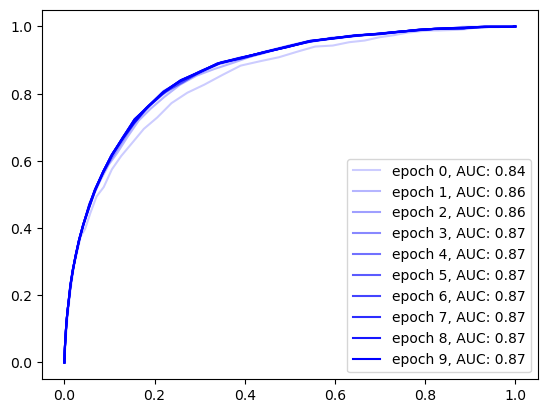

In [8]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.01, regtype='fp', casttoprob=False)

alphas = torch.linspace(0.2, 1, nepochs)
fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
update_tau(model, scores0, scores1, type="fp", value=0.2)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
for epoch in tqdm(range(nepochs)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        # loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0, scores1,
                   type="fp", value=0.2)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

There does seem to be some non-trivial inequality and the regularisation term does seem to accurately predict this. We now try actually performing the regularisation

 10%|█         | 1/10 [00:02<00:20,  2.25s/it]

Loss: 0.452 | Reg: 0.040 |  AUC: 0.835 | Equality Error: 0.037 |  FPR: 0.204 | TPR: 0.702 | FDR: 0.962


 20%|██        | 2/10 [00:04<00:16,  2.10s/it]

Loss: 0.410 | Reg: 0.031 |  AUC: 0.858 | Equality Error: 0.037 |  FPR: 0.203 | TPR: 0.768 | FDR: 0.958


 30%|███       | 3/10 [00:06<00:13,  1.94s/it]

Loss: 0.392 | Reg: 0.020 |  AUC: 0.857 | Equality Error: 0.021 |  FPR: 0.205 | TPR: 0.762 | FDR: 0.959


 40%|████      | 4/10 [00:07<00:11,  1.93s/it]

Loss: 0.369 | Reg: 0.004 |  AUC: 0.856 | Equality Error: 0.017 |  FPR: 0.201 | TPR: 0.756 | FDR: 0.958


 50%|█████     | 5/10 [00:09<00:09,  1.83s/it]

Loss: 0.396 | Reg: 0.008 |  AUC: 0.857 | Equality Error: 0.017 |  FPR: 0.194 | TPR: 0.747 | FDR: 0.957


 60%|██████    | 6/10 [00:11<00:06,  1.74s/it]

Loss: 0.383 | Reg: 0.021 |  AUC: 0.857 | Equality Error: 0.017 |  FPR: 0.200 | TPR: 0.753 | FDR: 0.958


 70%|███████   | 7/10 [00:12<00:05,  1.67s/it]

Loss: 0.393 | Reg: 0.000 |  AUC: 0.858 | Equality Error: 0.017 |  FPR: 0.199 | TPR: 0.751 | FDR: 0.958


 80%|████████  | 8/10 [00:14<00:03,  1.65s/it]

Loss: 0.408 | Reg: 0.006 |  AUC: 0.858 | Equality Error: 0.018 |  FPR: 0.202 | TPR: 0.759 | FDR: 0.959


 90%|█████████ | 9/10 [00:15<00:01,  1.61s/it]

Loss: 0.404 | Reg: 0.014 |  AUC: 0.858 | Equality Error: 0.018 |  FPR: 0.207 | TPR: 0.769 | FDR: 0.959


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

Loss: 0.382 | Reg: 0.031 |  AUC: 0.858 | Equality Error: 0.018 |  FPR: 0.198 | TPR: 0.751 | FDR: 0.958


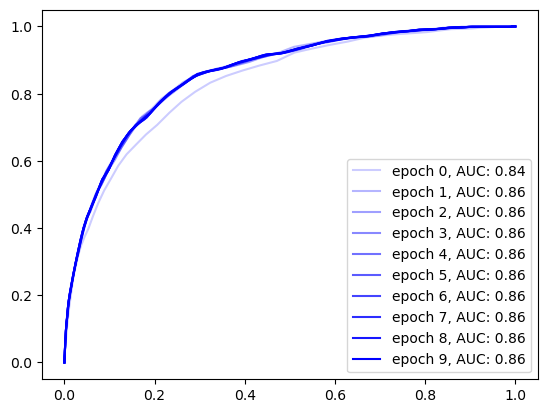

In [9]:
# Set up data
# Split into 0 and 1 data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10


# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)
alphas = torch.linspace(0.2,1,nepochs)

fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
model.tau = torch.quantile(scores0.detach(),torch.tensor([.8]))
for epoch in tqdm(range(nepochs)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(), type="fp", value=0.2)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

 10%|█         | 1/10 [00:02<00:19,  2.15s/it]

Loss: 0.525 | Reg: 0.005 |  AUC: 0.825 | Equality Error: 0.004 |  FPR: 0.205 | TPR: 0.697 | FDR: 0.962


 20%|██        | 2/10 [00:04<00:16,  2.10s/it]

Loss: 0.452 | Reg: 0.016 |  AUC: 0.848 | Equality Error: 0.007 |  FPR: 0.195 | TPR: 0.736 | FDR: 0.958


 30%|███       | 3/10 [00:06<00:14,  2.01s/it]

Loss: 0.395 | Reg: 0.008 |  AUC: 0.853 | Equality Error: 0.011 |  FPR: 0.200 | TPR: 0.744 | FDR: 0.959


 40%|████      | 4/10 [00:07<00:11,  1.85s/it]

Loss: 0.463 | Reg: 0.013 |  AUC: 0.854 | Equality Error: 0.015 |  FPR: 0.198 | TPR: 0.752 | FDR: 0.958


 50%|█████     | 5/10 [00:09<00:08,  1.76s/it]

Loss: 0.365 | Reg: 0.018 |  AUC: 0.852 | Equality Error: 0.010 |  FPR: 0.202 | TPR: 0.751 | FDR: 0.959


 60%|██████    | 6/10 [00:10<00:06,  1.67s/it]

Loss: 0.432 | Reg: 0.026 |  AUC: 0.853 | Equality Error: 0.011 |  FPR: 0.199 | TPR: 0.747 | FDR: 0.958


 70%|███████   | 7/10 [00:12<00:04,  1.63s/it]

Loss: 0.400 | Reg: 0.005 |  AUC: 0.853 | Equality Error: 0.010 |  FPR: 0.201 | TPR: 0.751 | FDR: 0.959


 80%|████████  | 8/10 [00:13<00:03,  1.63s/it]

Loss: 0.400 | Reg: 0.018 |  AUC: 0.853 | Equality Error: 0.010 |  FPR: 0.198 | TPR: 0.749 | FDR: 0.958


 90%|█████████ | 9/10 [00:15<00:01,  1.62s/it]

Loss: 0.412 | Reg: 0.001 |  AUC: 0.853 | Equality Error: 0.010 |  FPR: 0.198 | TPR: 0.747 | FDR: 0.958


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

Loss: 0.434 | Reg: 0.008 |  AUC: 0.853 | Equality Error: 0.010 |  FPR: 0.193 | TPR: 0.739 | FDR: 0.958


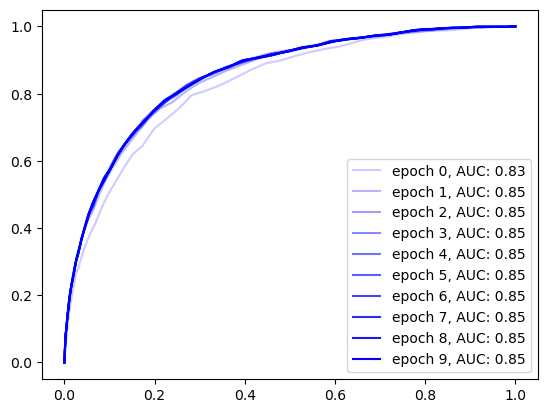

In [13]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
d = X_train.shape[1]
lossfunc = paired_aucloss
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)

model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
alphas = torch.linspace(0.2, 1, nepochs)

fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
model.tau = torch.quantile(scores0.detach(),torch.tensor([.8]))
for epoch in tqdm(range(10)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += 2*reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(), type="fp", value=0.2)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

### Set Small Prop

 10%|█         | 1/10 [00:01<00:17,  1.98s/it]

Loss: 0.460 | Reg: 0.001 |  AUC: 0.839 | Equality Error: 0.004 | Equal Error Logit: 0.596 |  FPR: 0.008 | TPR: 0.142 | FDR: 0.829


 20%|██        | 2/10 [00:03<00:15,  1.92s/it]

Loss: 0.377 | Reg: 0.003 |  AUC: 0.862 | Equality Error: 0.005 | Equal Error Logit: 0.668 |  FPR: 0.008 | TPR: 0.155 | FDR: 0.810


 30%|███       | 3/10 [00:06<00:15,  2.15s/it]

Loss: 0.363 | Reg: 0.008 |  AUC: 0.863 | Equality Error: 0.005 | Equal Error Logit: 0.740 |  FPR: 0.008 | TPR: 0.168 | FDR: 0.808


 40%|████      | 4/10 [00:08<00:12,  2.06s/it]

Loss: 0.357 | Reg: 0.004 |  AUC: 0.865 | Equality Error: 0.005 | Equal Error Logit: 0.717 |  FPR: 0.009 | TPR: 0.171 | FDR: 0.812


 50%|█████     | 5/10 [00:10<00:10,  2.01s/it]

Loss: 0.355 | Reg: 0.004 |  AUC: 0.866 | Equality Error: 0.006 | Equal Error Logit: 0.753 |  FPR: 0.009 | TPR: 0.172 | FDR: 0.813


 60%|██████    | 6/10 [00:11<00:07,  1.92s/it]

Loss: 0.364 | Reg: 0.005 |  AUC: 0.866 | Equality Error: 0.006 | Equal Error Logit: 0.753 |  FPR: 0.009 | TPR: 0.175 | FDR: 0.810


 70%|███████   | 7/10 [00:13<00:05,  1.97s/it]

Loss: 0.331 | Reg: 0.011 |  AUC: 0.866 | Equality Error: 0.005 | Equal Error Logit: 0.780 |  FPR: 0.007 | TPR: 0.159 | FDR: 0.802


 80%|████████  | 8/10 [00:15<00:03,  1.91s/it]

Loss: 0.371 | Reg: 0.003 |  AUC: 0.866 | Equality Error: 0.006 | Equal Error Logit: 0.764 |  FPR: 0.008 | TPR: 0.171 | FDR: 0.809


 90%|█████████ | 9/10 [00:17<00:01,  1.94s/it]

Loss: 0.367 | Reg: 0.005 |  AUC: 0.866 | Equality Error: 0.005 | Equal Error Logit: 0.777 |  FPR: 0.008 | TPR: 0.160 | FDR: 0.807


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]

Loss: 0.353 | Reg: 0.005 |  AUC: 0.866 | Equality Error: 0.006 | Equal Error Logit: 0.757 |  FPR: 0.008 | TPR: 0.171 | FDR: 0.808


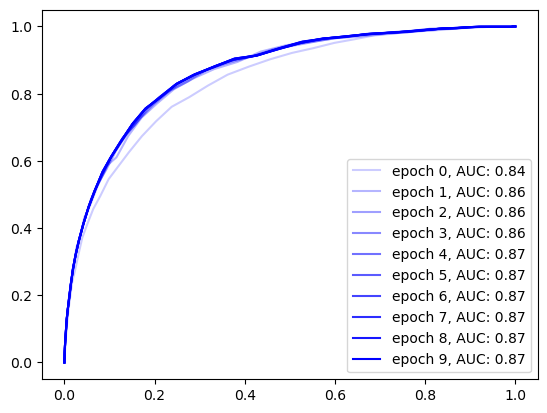

In [82]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
prior_tr = torch.mean(y_train)
prop_1 = 0.01
d = X_train.shape[1]
lossfunc = paired_aucloss
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)

model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
alphas = torch.linspace(0.2, 1, nepochs)

fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
model.tau = torch.quantile(scores0.detach(),torch.tensor([.8]))
for epoch in tqdm(range(10)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += 2*reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1, prior=prior)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        equal_error_logit = equality_loss(y_test, pred_te, income_test, regtype='fp', logit=True)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | Equal Error Logit:{equal_error_logit.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

## Multiple Experiments

In [88]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10
# Set-up model
d = X_train.shape[1]
lossfunc = paired_aucloss
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)
tau = 0.01

equal_losses = []
aucs = []
rocs = []
single_tprs = []
equal_losses_logit = []
lambs = [0.,0.5,1.,1.5,2.]
nrep = 10
for lamb in tqdm(lambs):
    for j in range(nrep):
        # Set-up model
        model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
        # Train model
        (x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 20% FP rate
        update_tau(model, scores0.detach(), scores1.detach(), type="fp", value=0.2)
        scores1 = scores1.repeat(batch_rep)
        for epoch in range(10):
            for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
                optimizer.zero_grad()
                loss = lossfunc(scores0, scores1)
                loss += lamb*reg
                loss.backward()
                optimizer.step()
                scores0 = model(x0).squeeze()
                scores1 = model(x1).squeeze()
                reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
                # Use 0 scores to update tau to give 25% FP rate
                update_tau(model, scores0.detach(), scores1.detach(), type="fp", value=0.2)
                # upscale scores to be same length as scores0
                scores1 = scores1.repeat(batch_rep)
            scheduler.step()
        with torch.no_grad():
            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            # Get Odd loss 
            equal_loss = equality_loss(y_test, pred_te, income_test, regtype='fp').item()
            equal_loss_logit = equality_loss(y_test, pred_te, income_test, regtype='fp', logit=True).item()
            single_fpr = FPR(pred_te, y_test)
            single_tpr = TPR(pred_te, y_test)
            equal_losses.append(equal_loss)
            equal_losses_logit.append(equal_loss_logit)
            fpr, tpr = roc(scores_te, y_test)
            rocs.append([fpr, tpr])
            auc = AUC(fpr, tpr)
            aucs.append(auc)
            single_tprs.append(single_tpr.item())
        del model

result_dict = {'equal_losses': equal_losses, 'aucs': aucs, 'rocs': rocs, 
               "single_tprs": single_tprs, "equal_losses_logit": equal_losses_logit}

result_dict_tensor = {key: torch.tensor(value) for key, value in result_dict.items()}
result_dict_tensor = {key: value.reshape(len(lambs), nrep, *value[0,...].shape) 
                      for key, value in result_dict_tensor.items()}

torch.save(result_dict_tensor | {"lambdas": lambs},
           'AUC_init_results.pt')

100%|██████████| 5/5 [09:22<00:00, 112.52s/it]


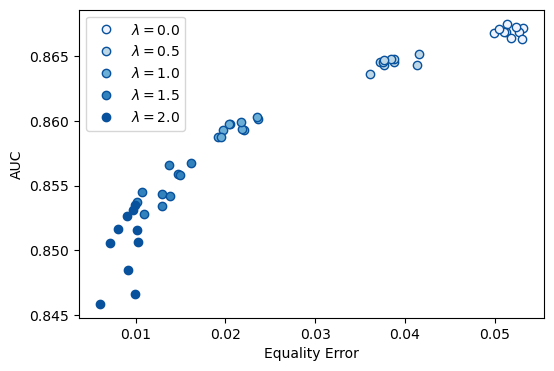

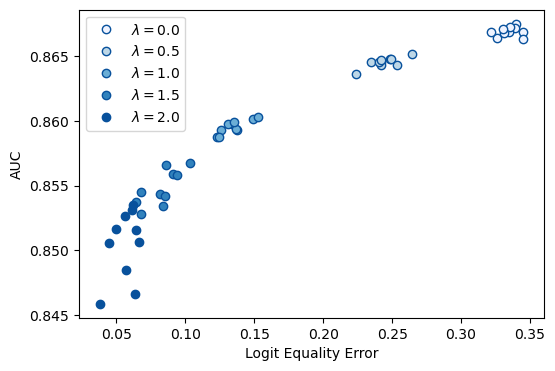

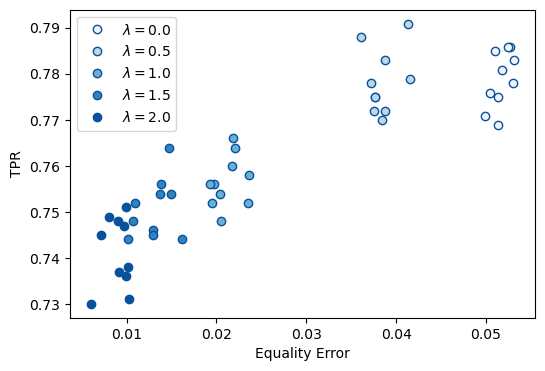

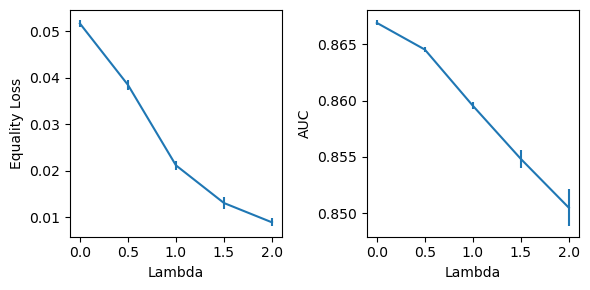

In [72]:

results = torch.load('AUC_init_results.pt')
equal_losses, aucs, rocs, equal_losses_logit, single_tprs, lambs = [
    results[key] for key in ["equal_losses", "aucs", "rocs", "equal_losses_logit", "single_tprs", "lambdas"]]
nrep=int(equal_losses.shape[1])
alphas = torch.linspace(0.2, 1, len(lambs))
lambda_cols = ["#eff3ff", "#bdd7e7", "#6baed6", "#3182bd", "#08519c"]
fig, ax = plt.subplots(figsize=(6,4))
for i,lamb in enumerate(lambs):
    ax.plot(equal_losses[i], aucs[i], 'o', label = r"$\lambda=$"+f'{lamb}', color=lambda_cols[i],markeredgecolor='#08519c')
ax.set_xlabel('Equality Error')
ax.set_ylabel('AUC')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
for i,lamb in enumerate(lambs):
    ax.plot(equal_losses_logit[i], aucs[i], 'o', label = r"$\lambda=$"+f'{lamb}', color=lambda_cols[i],markeredgecolor='#08519c')
ax.set_xlabel('Logit Equality Error')
ax.set_ylabel('AUC')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
for i,lamb in enumerate(lambs):
    ax.plot(equal_losses[i], single_tprs[i], 'o', label = r"$\lambda=$"+f'{lamb}', color=lambda_cols[i],markeredgecolor='#08519c')
ax.set_xlabel('Equality Error')
ax.set_ylabel('TPR')
ax.legend()
fig, ax = plt.subplots(ncols=2, figsize=(6,3))
ax[0].errorbar(lambs, torch.mean(equal_losses, dim=1), yerr=1.96*torch.std(equal_losses, dim=1)/nrep**0.5, label = 'Mean Equal Loss')
ax[0].set_xlabel('Lambda')
ax[0].set_ylabel('Equality Loss')
ax[1].errorbar(lambs, torch.mean(aucs, dim=1), yerr=1.96*torch.std(aucs, dim=1)/nrep**0.5, label = 'Mean AUC')
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('AUC')
fig.tight_layout()


### Smaller Proportion

In [89]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10
# Set-up model
d = X_train.shape[1]
lossfunc = paired_aucloss
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)
tau = 0.01
prop_1 = 0.01
prior_tr = torch.mean(y_train)

equal_losses = []
aucs = []
rocs = []
single_tprs = []
equal_losses_logit = []
lambs = [0.,2.5,5.,7.5,10.]
nrep = 10
for lamb in tqdm(lambs):
    for j in range(nrep):
        # Set-up model
        model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
        # Train model
        (x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 20% FP rate
        update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1, prior=prior_tr)
        scores1 = scores1.repeat(batch_rep)
        for epoch in range(10):
            for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
                optimizer.zero_grad()
                loss = lossfunc(scores0, scores1)
                loss += lamb*reg
                loss.backward()
                optimizer.step()
                scores0 = model(x0).squeeze()
                scores1 = model(x1).squeeze()
                reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
                # Use 0 scores to update tau to give 25% FP rate
                update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1, prior=prior_tr)
                # upscale scores to be same length as scores0
                scores1 = scores1.repeat(batch_rep)
            scheduler.step()
        with torch.no_grad():
            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            # Get Odd loss 
            equal_loss = equality_loss(y_test, pred_te, income_test, regtype='fp').item()
            equal_loss_logit = equality_loss(y_test, pred_te, income_test, regtype='fp', logit=True).item()
            single_fpr = FPR(pred_te, y_test)
            single_tpr = TPR(pred_te, y_test)
            equal_losses.append(equal_loss)
            equal_losses_logit.append(equal_loss_logit)
            fpr, tpr = roc(scores_te, y_test)
            rocs.append([fpr, tpr])
            auc = AUC(fpr, tpr)
            aucs.append(auc)
            single_tprs.append(single_tpr.item())
        del model

result_dict = {'equal_losses': equal_losses, 'aucs': aucs, 'rocs': rocs, 
               "single_tprs": single_tprs, "equal_losses_logit": equal_losses_logit}

result_dict_tensor = {key: torch.tensor(value) for key, value in result_dict.items()}
result_dict_tensor = {key: value.reshape(len(lambs), nrep, *value[0,...].shape) 
                      for key, value in result_dict_tensor.items()}

torch.save(result_dict_tensor | {"lambdas": lambs},
           'AUC_prop_results.pt')

100%|██████████| 5/5 [09:14<00:00, 110.88s/it]


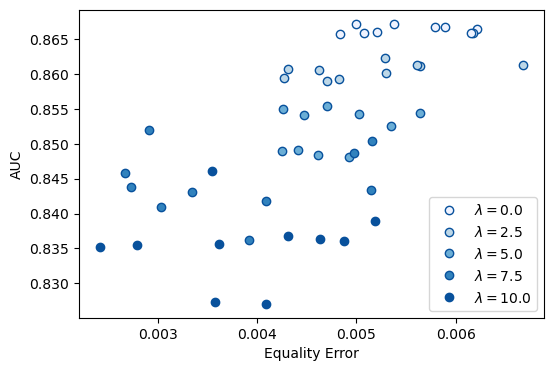

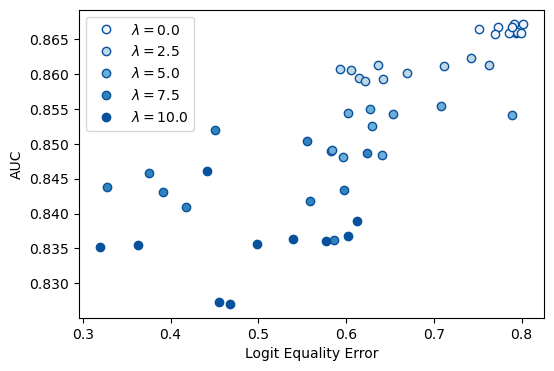

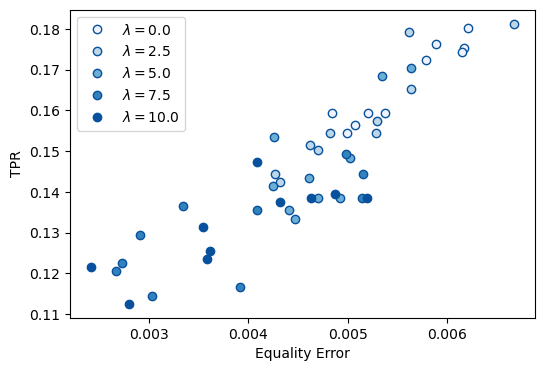

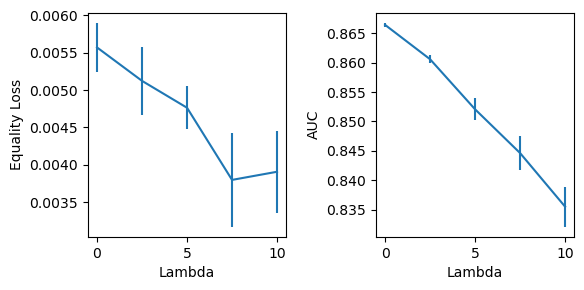

In [48]:

results = torch.load('AUC_prop_results.pt')
equal_losses, aucs, rocs, equal_losses_logit, single_tprs, lambs = [
    results[key] for key in ["equal_losses", "aucs", "rocs", "equal_losses_logit", "single_tprs", "lambdas"]]
nrep=int(equal_losses.shape[1])
alphas = torch.linspace(0.2, 1, len(lambs))
lambda_cols = ["#eff3ff", "#bdd7e7", "#6baed6", "#3182bd", "#08519c"]
fig, ax = plt.subplots(figsize=(6,4))
for i,lamb in enumerate(lambs):
    ax.plot(equal_losses[i], aucs[i], 'o', label = r"$\lambda=$"+f'{lamb}', color=lambda_cols[i],markeredgecolor='#08519c')
ax.set_xlabel('Equality Error')
ax.set_ylabel('AUC')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
for i,lamb in enumerate(lambs):
    ax.plot(equal_losses_logit[i], aucs[i], 'o', label = r"$\lambda=$"+f'{lamb}', color=lambda_cols[i],markeredgecolor='#08519c')
ax.set_xlabel('Logit Equality Error')
ax.set_ylabel('AUC')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
for i,lamb in enumerate(lambs):
    ax.plot(equal_losses[i], single_tprs[i], 'o', label = r"$\lambda=$"+f'{lamb}', color=lambda_cols[i],markeredgecolor='#08519c')
ax.set_xlabel('Equality Error')
ax.set_ylabel('TPR')
ax.legend()
fig, ax = plt.subplots(ncols=2, figsize=(6,3))
ax[0].errorbar(lambs, torch.mean(equal_losses, dim=1), yerr=1.96*torch.std(equal_losses, dim=1)/nrep**0.5, label = 'Mean Equal Loss')
ax[0].set_xlabel('Lambda')
ax[0].set_ylabel('Equality Loss')
ax[1].errorbar(lambs, torch.mean(aucs, dim=1), yerr=1.96*torch.std(aucs, dim=1)/nrep**0.5, label = 'Mean AUC')
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('AUC')
fig.tight_layout()


## Explore Thresholding

In [63]:
test_taus = {}
fprs = {}
fprs_group0 = {}
fprs_group1 = {}
equal_losses = {}
true_tau_train = {}
fpr_train_tau = {}
true_tau = {}

### No Regularisation

In [73]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)

key="no_reg"
# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
update_tau(model, scores0.detach(), scores1.detach(), type="fp", value=0.2)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
for epoch in tqdm(range(nepochs)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="fp", value=0.2)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
true_tau_train[key] = deepcopy(model.tau)


fprs = {}
fprs_group0 = {}
fprs_group1 = {}
equal_losses = {}
key="no_reg"
# Test
with torch.no_grad():
    # Set up storage
    fprs[key] = []
    fprs_group0[key] = []
    fprs_group1[key] = []
    equal_losses[key] = []
    scores_te = model(X_test).squeeze()
    scores0_te = scores_te[y_test==0]
    scores1_te = scores_te[y_test==1]
    pred_te = model.predict(X_test).squeeze()
    fpr_train_tau[key] = FPR(pred_te, y_test).item()

    tau_min = torch.quantile(scores0_te, torch.tensor([0.01])).item()
    tau_max = torch.quantile(scores0_te, torch.tensor([0.99])).item()
    test_taus[key] = torch.linspace(tau_min, tau_max, 100)
    for tau in test_taus[key]:
        model.tau = tau
        pred_te = model.predict(X_test).squeeze()
        fpr = FPR(pred_te, y_test)
        fpr_group0 = FPR(pred_te[income_test==0], y_test[income_test==0])
        fpr_group1 = FPR(pred_te[income_test==1], y_test[income_test==1])
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        fprs[key].append(fpr.item())
        fprs_group0[key].append(fpr_group0.item())
        fprs_group1[key].append(fpr_group1.item())
        equal_losses[key].append(equal_error.item())
    true_tau[key] = torch.quantile(scores0_te, torch.tensor([0.8])).item()

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Text(0, 0.5, 'Equality Loss')

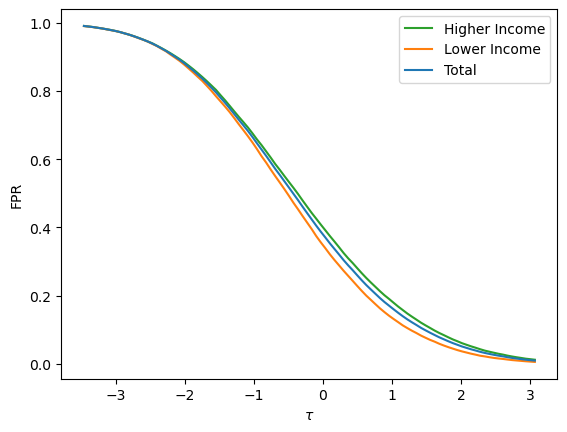

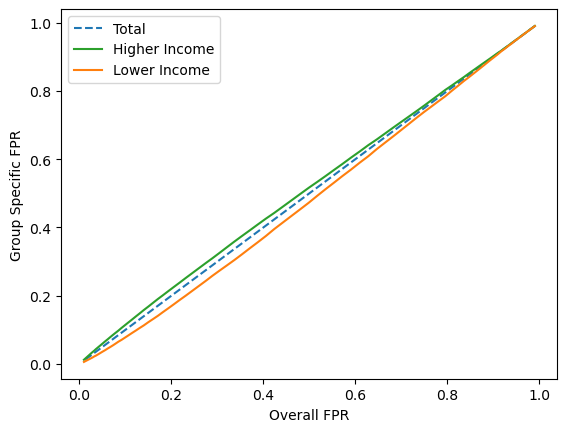

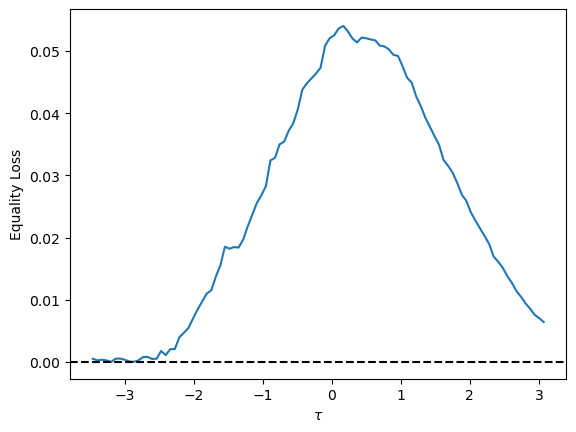

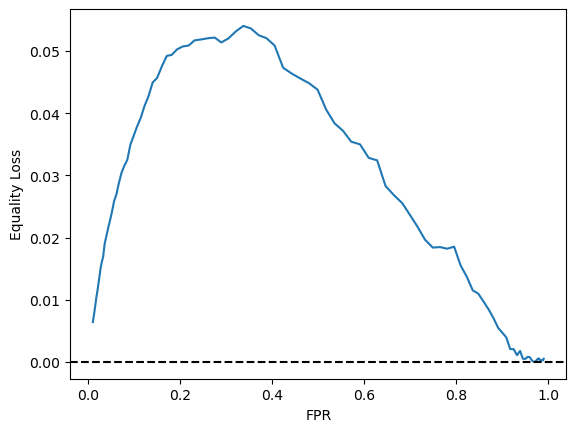

In [85]:
key = "no_reg"
fig, ax = plt.subplots()
ax.plot(test_taus[key], fprs_group1[key], label='Higher Income', color="C2")
ax.plot(test_taus[key], fprs_group0[key], label='Lower Income', color="C1")
ax.plot(test_taus[key], fprs[key], label='Total', color="C0")
ax.legend()
ax.set_xlabel(r"$\tau$")
ax.set_ylabel('FPR')

fig, ax = plt.subplots()
ax.plot(fprs[key], fprs[key], label='Total', color="C0", linestyle="--")
ax.plot(fprs[key], fprs_group1[key], label='Higher Income', color="C2")
ax.plot(fprs[key], fprs_group0[key], label='Lower Income', color="C1")
ax.legend()
ax.set_xlabel("Overall FPR")
ax.set_ylabel("Group Specific FPR")

fig, ax = plt.subplots()
ax.plot(test_taus[key], equal_losses[key])
# Horizontsal black dashed line at 0
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel(r"$\tau$")
ax.set_ylabel('Equality Loss')

fig, ax = plt.subplots()
ax.plot(fprs[key], equal_losses[key])
# Horizontal black dashed line at 0
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel('FPR')
ax.set_ylabel('Equality Loss')

### With Regularisation

In [75]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
d = X_train.shape[1]
lossfunc = paired_aucloss
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)

model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)

key = "reg"
# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
update_tau(model, scores0.detach(), scores1.detach(), type="fp", value=0.2)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
for epoch in tqdm(range(nepochs)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += 1.5*reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="fp", value=0.2)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
true_tau_train[key] = deepcopy(model.tau)


# Test
with torch.no_grad():
    # Set up storage
    fprs[key] = []
    fprs_group0[key] = []
    fprs_group1[key] = []
    equal_losses[key] = []
    scores_te = model(X_test).squeeze()
    scores0_te = scores_te[y_test==0]
    scores1_te = scores_te[y_test==1]
    pred_te = model.predict(X_test).squeeze()
    fpr_train_tau[key] = FPR(pred_te, y_test).item()
    
    tau_min = torch.quantile(scores0_te, torch.tensor([0.01])).item()
    tau_max = torch.quantile(scores0_te, torch.tensor([0.99])).item()
    test_taus[key] = torch.linspace(tau_min, tau_max, 100)
    for tau in test_taus[key]:
        model.tau = tau
        pred_te = model.predict(X_test).squeeze()
        fpr = FPR(pred_te, y_test)
        fpr_group0 = FPR(pred_te[income_test==0], y_test[income_test==0])
        fpr_group1 = FPR(pred_te[income_test==1], y_test[income_test==1])
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        fprs[key].append(fpr.item())
        fprs_group0[key].append(fpr_group0.item())
        fprs_group1[key].append(fpr_group1.item())
        equal_losses[key].append(equal_error.item())
    
    true_tau[key] = torch.quantile(scores0_te, torch.tensor([0.8])).item()

100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Text(0, 0.5, 'Equality Loss')

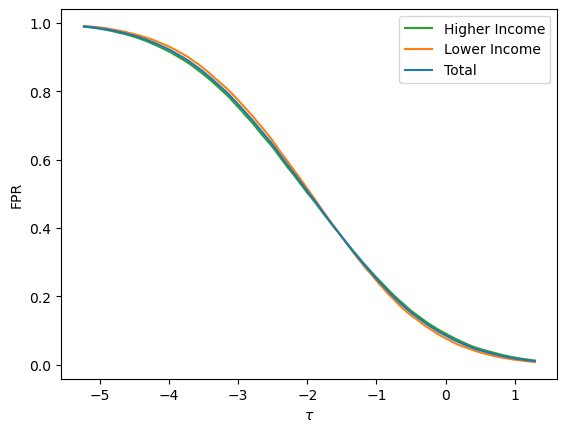

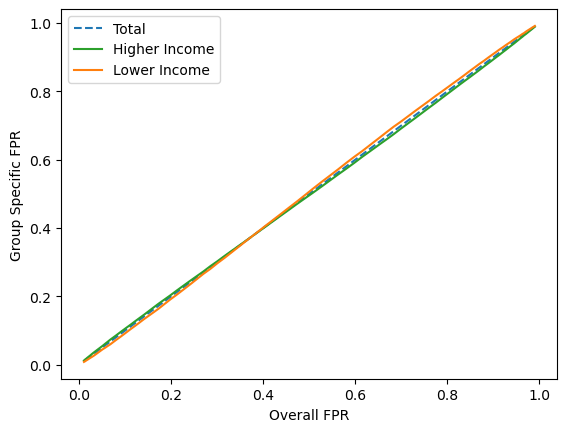

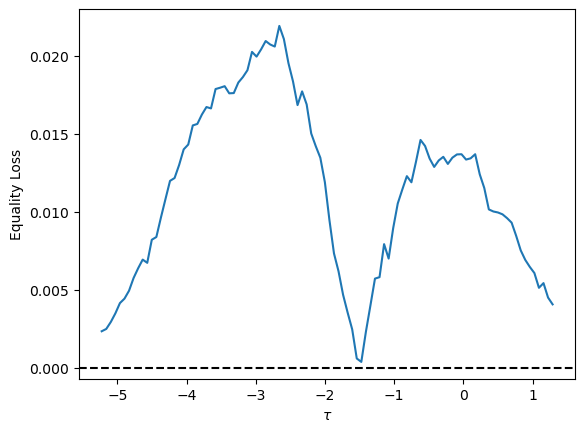

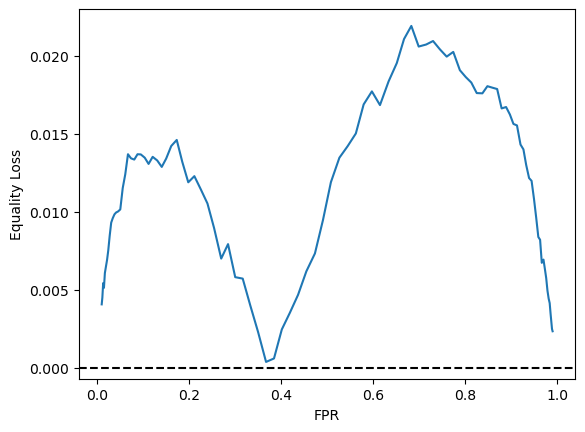

In [84]:
key = "reg"
fig, ax = plt.subplots()
ax.plot(test_taus[key], fprs_group1[key], label='Higher Income', color="C2")
ax.plot(test_taus[key], fprs_group0[key], label='Lower Income', color="C1")
ax.plot(test_taus[key], fprs[key], label='Total', color="C0")
ax.legend()
ax.set_xlabel(r"$\tau$")
ax.set_ylabel('FPR')

fig, ax = plt.subplots()
ax.plot(fprs[key], fprs[key], label='Total', color="C0", linestyle="--")
ax.plot(fprs[key], fprs_group1[key], label='Higher Income', color="C2")
ax.plot(fprs[key], fprs_group0[key], label='Lower Income', color="C1")
ax.legend()
ax.set_xlabel("Overall FPR")
ax.set_ylabel("Group Specific FPR")

fig, ax = plt.subplots()
ax.plot(test_taus[key], equal_losses[key])
# Horizontsal black dashed line at 0
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel(r"$\tau$")
ax.set_ylabel('Equality Loss')

fig, ax = plt.subplots()
ax.plot(fprs[key], equal_losses[key])
# Horizontal black dashed line at 0
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel('FPR')
ax.set_ylabel('Equality Loss')

Text(0, 0.5, 'Equality Loss')

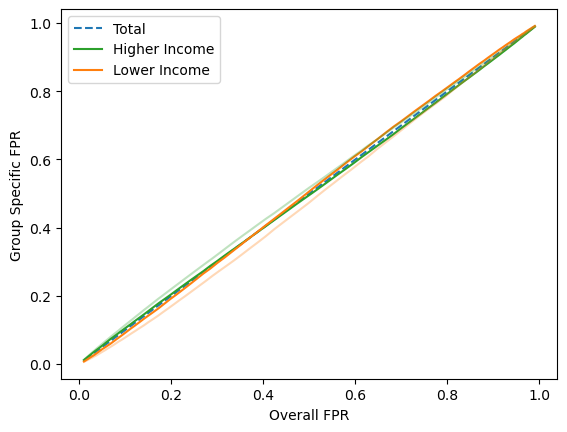

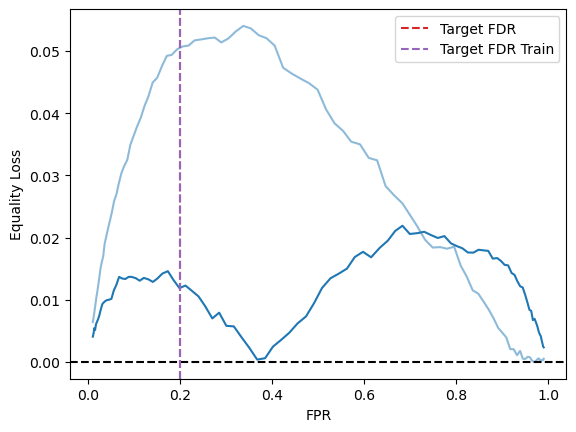

In [83]:
fig, ax = plt.subplots()
ax.plot(fprs["reg"], fprs["reg"], label='Total', color="C0", linestyle="--")
ax.plot(fprs["reg"], fprs_group1["reg"], label='Higher Income', color="C2")
ax.plot(fprs["reg"], fprs_group0["reg"], label='Lower Income', color="C1")
ax.plot(fprs["no_reg"], fprs_group1["no_reg"], alpha=0.3, color="C2")
ax.plot(fprs["no_reg"], fprs_group0["no_reg"], alpha=0.3, color="C1")
ax.legend()
ax.set_xlabel("Overall FPR")
ax.set_ylabel("Group Specific FPR")

fig, ax = plt.subplots()
ax.plot(fprs["reg"], equal_losses["reg"], color="C0")
ax.plot(fprs["no_reg"], equal_losses["no_reg"], color="C0", alpha=0.5)
# Horizontal black dashed line at 0
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0.2, color='C3', linestyle='--', label='Target FDR')
ax.axvline(fpr_train_tau["reg"], color='C4', linestyle='--', label='Target FDR Train')
ax.legend()
ax.set_xlabel('FPR')
ax.set_ylabel('Equality Loss')

### With Regularisation after $\tau$ update

In [54]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)

# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
update_tau(model, scores0.detach(), scores1.detach(), type="fp", value=0.2)
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
for epoch in tqdm(range(nepochs)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += 1.5*reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="fp", value=0.2)
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    true_tau_train = deepcopy(model.tau)

# Test
with torch.no_grad():
    # Set up storage
    fprs = []
    fprs_group0 = []
    fprs_group1 = []
    equal_losses = []
    scores_te = model(X_test).squeeze()
    scores0_te = scores_te[y_test==0]
    scores1_te = scores_te[y_test==1]
    pred_te = model.predict(X_test).squeeze()
    fpr_train_tau = FPR(pred_te, y_test).item()
    
    tau_min = torch.quantile(scores0_te, torch.tensor([0.01])).item()
    tau_max = torch.quantile(scores0_te, torch.tensor([0.99])).item()
    taus = torch.linspace(tau_min, tau_max, 100)
    for tau in taus:
        model.tau = tau
        pred_te = model.predict(X_test).squeeze()
        fpr = FPR(pred_te, y_test)
        fpr_group0 = FPR(pred_te[income_test==0], y_test[income_test==0])
        fpr_group1 = FPR(pred_te[income_test==1], y_test[income_test==1])
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        fprs.append(fpr.item())
        fprs_group0.append(fpr_group0.item())
        fprs_group1.append(fpr_group1.item())
        equal_losses.append(equal_error.item())
    
    true_tau = torch.quantile(scores0_te, torch.tensor([0.8])).item()

100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Text(0, 0.5, 'Equality Loss')

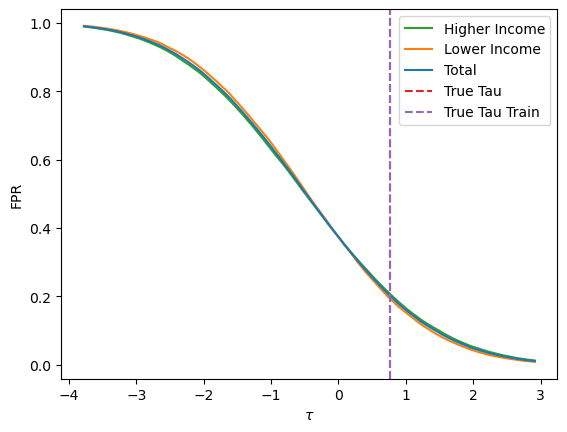

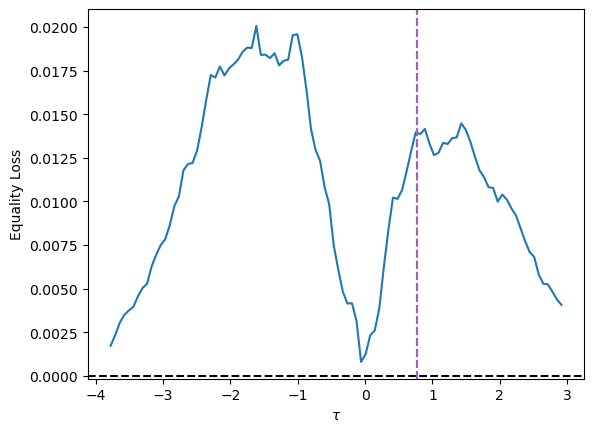

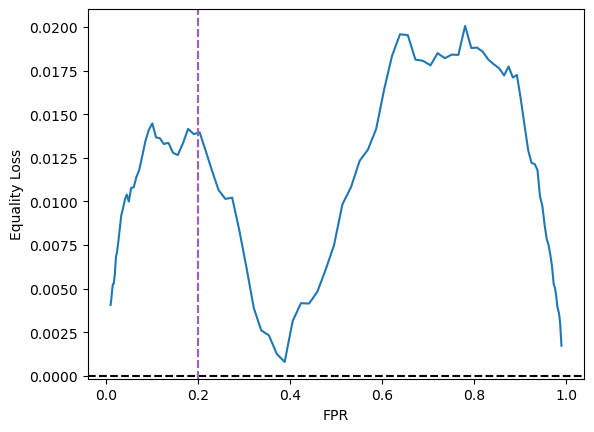

In [55]:
fig, ax = plt.subplots()
ax.plot(taus, fprs_group1, label='Higher Income', color="C2")
ax.plot(taus, fprs_group0, label='Lower Income', color="C1")
ax.plot(taus, fprs, label='Total', color="C0")
ax.axvline(true_tau, color='C3', linestyle='--', label='True Tau')
ax.axvline(true_tau_train, color='C4', linestyle='--', label='True Tau Train')
ax.legend()
ax.set_xlabel(r"$\tau$")
ax.set_ylabel('FPR')

fig, ax = plt.subplots()
ax.plot(taus, equal_losses)
# Horizontsal black dashed line at 0
ax.axhline(0, color='black', linestyle='--')
ax.axvline(true_tau, color='C3', linestyle='--', label='True Tau')
ax.axvline(true_tau_train, color='C4', linestyle='--', label='True Tau Train')
ax.set_xlabel(r"$\tau$")
ax.set_ylabel('Equality Loss')

fig, ax = plt.subplots()
ax.plot(fprs, equal_losses)
# Horizontal black dashed line at 0
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0.2, color='C3', linestyle='--', label='Target FDR')
ax.axvline(fpr_train_tau, color='C4', linestyle='--', label='Target FDR Train')
ax.set_xlabel('FPR')
ax.set_ylabel('Equality Loss')

## Comparing AUCs

In [14]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
d = X_train.shape[1]
lossfunc = paired_aucloss

regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)
def no_regularise(*args, **kwargs):
    return torch.tensor(0.)

regularisers = {"reg": regularise, "no_reg": no_regularise}
models = {}
optimizers = {}
schedulers = {}
for key, reg in regularisers.items():
    model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
    models[key] = model
    optimizers[key] = optimizer
    schedulers[key] = scheduler

scores0 = {}
scores1 = {}
reg = {}
# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
for key in models.keys():
    scores0[key] = models[key](x0).squeeze()
    scores1[key] = models[key](x1).squeeze()
    reg[key] = regularisers[key](scores0[key], scores1[key], income0, income1, tau=models[key].tau)
    update_tau(models[key], scores0[key].detach(), scores1[key].detach(), type="fp", value=0.2)
    scores1[key] = scores1[key].repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
for epoch in tqdm(range(nepochs)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        for key in models.keys():
            optimizers[key].zero_grad()
            loss = lossfunc(scores0[key], scores1[key])
            loss += 1.5*reg[key]
            loss.backward()
            optimizers[key].step()
            scores0[key] = models[key](x0).squeeze()
            scores1[key] = models[key](x1).squeeze()
            reg[key] = regularisers[key](scores0[key], scores1[key], income0, income1, tau=models[key].tau)
            # Use 0 scores to update tau to give 25% FP rate
            update_tau(models[key], scores0[key].detach(), scores1[key].detach(),
                    type="fp", value=0.2)
            # upscale scores to be same length as scores0
            scores1[key] = scores1[key].repeat(batch_rep)
    schedulers[key].step()


rocs = {}
rocs_group0 = {}
rocs_group1 = {}
actual_fpr = {}
y_test_group0 = y_test[income_test==0]
y_test_group1 = y_test[income_test==1]
for key in models.keys():
    true_tau_train[key] = deepcopy(models[key].tau)
    # Test
    with torch.no_grad():
        # Set up storage
        fprs[key] = []
        fprs_group0[key] = []
        fprs_group1[key] = []
        equal_losses[key] = []
        scores_te = models[key](X_test).squeeze()
        scores_group0 = scores_te[income_test==0]
        scores_group1 = scores_te[income_test==1]
        
        pred_te = models[key].predict(X_test).squeeze()
        all_fprs, all_tprs = roc(scores_te, y_test)
        all_fprs_group0, all_tprs_group0 = roc(scores_group0, y_test_group0)
        all_fprs_group1, all_tprs_group1 = roc(scores_group1, y_test_group1)
        rocs[key] = (all_fprs, all_tprs)
        rocs_group0[key] = (all_fprs_group0, all_tprs_group0)
        rocs_group1[key] = (all_fprs_group1, all_tprs_group1)
        actual_fpr[key] = FPR(pred_te, y_test).item()

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Text(0, 0.5, 'FPR')

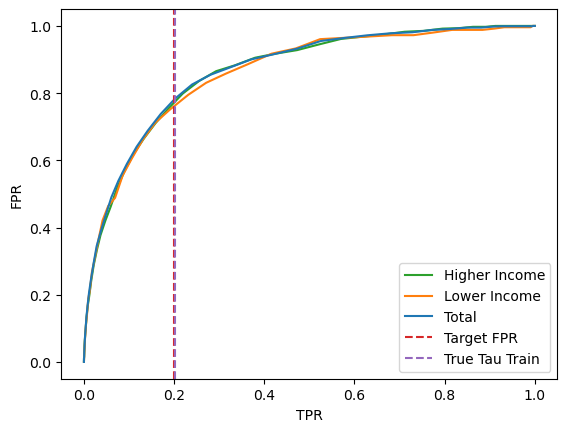

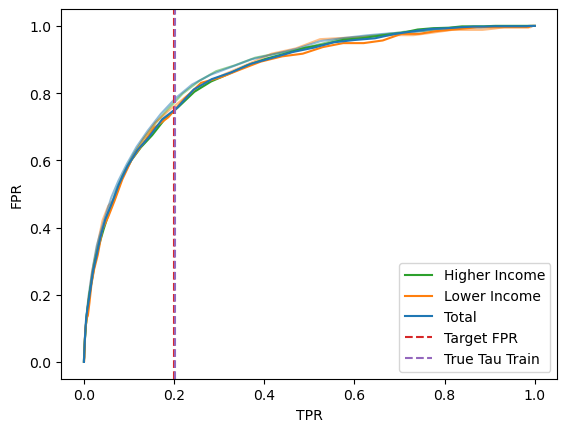

In [20]:
alphas = [0.5,1]
fig, ax = plt.subplots()
ax.plot(rocs_group1["no_reg"][0], rocs_group1["no_reg"][1], label='Higher Income', color="C2")
ax.plot(rocs_group0["no_reg"][0], rocs_group0["no_reg"][1], label='Lower Income', color="C1")
ax.plot(rocs["no_reg"][0], rocs["no_reg"][1], label='Total', color="C0")
ax.axvline(0.2, color='C3', linestyle='--', label='Target FPR')
ax.axvline(actual_fpr["no_reg"], color='C4', linestyle='--', label='True Tau Train')
ax.legend()
ax.set_xlabel(r"TPR")
ax.set_ylabel('FPR')

fig, ax = plt.subplots()

ax.plot(rocs_group1["no_reg"][0], rocs_group1["no_reg"][1], color="C2", alpha=0.5)
ax.plot(rocs_group0["no_reg"][0], rocs_group0["no_reg"][1], color="C1", alpha=0.5)
ax.plot(rocs["no_reg"][0], rocs["no_reg"][1], color="C0", alpha=0.5)

ax.plot(rocs_group1["reg"][0], rocs_group1["reg"][1], label='Higher Income', color="C2", alpha=1)
ax.plot(rocs_group0["reg"][0], rocs_group0["reg"][1], label='Lower Income', color="C1", alpha=1)
ax.plot(rocs["reg"][0], rocs["reg"][1], label='Total', color="C0", alpha=1)
ax.axvline(0.2, color='C3', linestyle='--', label='Target FPR')
ax.axvline(actual_fpr["reg"], color='C4', linestyle='--', label='True Tau Train')
ax.legend()
ax.set_xlabel(r"TPR")
ax.set_ylabel('FPR')

# FDR Control 
We see from these approaches that even with strong FP and TP rates the FDR is very poor. We now see what happens if we control FDR specifically

## Fixed Proportion

No regularisation

 10%|█         | 1/10 [00:01<00:13,  1.50s/it]

Loss: 0.405 | Reg: 0.002 |  AUC: 0.843 | Equality Error: 0.004 | FDR Equal Error: 0.099 FPR: 0.008 | TPR: 0.144 | FDR: 0.823


 20%|██        | 2/10 [00:03<00:15,  1.91s/it]

Loss: 0.381 | Reg: 0.004 |  AUC: 0.861 | Equality Error: 0.005 | FDR Equal Error: 0.052 FPR: 0.008 | TPR: 0.160 | FDR: 0.816


 20%|██        | 2/10 [00:04<00:18,  2.33s/it]


KeyboardInterrupt: 

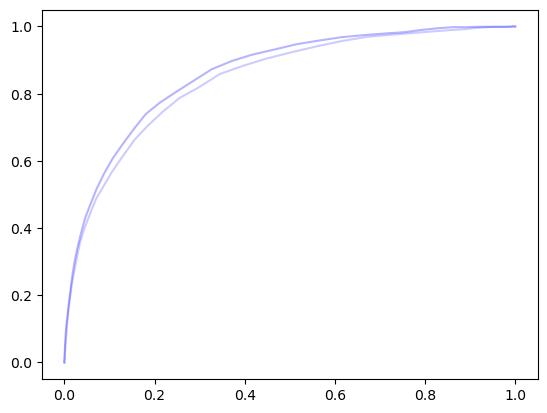

In [67]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1)
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Get priors
prior = torch.mean(y_train)
groups = torch.unique(income_train)
prior_groups = [torch.mean(y_train[income_train==group]) for group in groups]

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.01
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
update_tau(model, scores0, scores1, type="prop1", value=prop_1)
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in tqdm(range(10)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0, scores1,
                   type="prop1", value=prop_1, prior=prior)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

Here the FDR equality error is over 10 times larger than the equality error. We see if normal regularisation helps this

 10%|█         | 1/10 [00:02<00:20,  2.28s/it]

Loss: 0.502 | Reg: 0.004 |  AUC: 0.823 | Equality Error: 0.005 | FDR Equal Error: 0.052 FPR: 0.008 | TPR: 0.127 | FDR: 0.837


 20%|██        | 2/10 [00:04<00:16,  2.05s/it]

Loss: 0.470 | Reg: 0.002 |  AUC: 0.823 | Equality Error: 0.005 | FDR Equal Error: 0.042 FPR: 0.009 | TPR: 0.131 | FDR: 0.858


 30%|███       | 3/10 [00:06<00:15,  2.15s/it]

Loss: 0.477 | Reg: 0.003 |  AUC: 0.822 | Equality Error: 0.005 | FDR Equal Error: 0.043 FPR: 0.010 | TPR: 0.137 | FDR: 0.865


 40%|████      | 4/10 [00:08<00:12,  2.11s/it]

Loss: 0.500 | Reg: 0.000 |  AUC: 0.833 | Equality Error: 0.004 | FDR Equal Error: 0.053 FPR: 0.008 | TPR: 0.139 | FDR: 0.838


 50%|█████     | 5/10 [00:10<00:10,  2.02s/it]

Loss: 0.443 | Reg: 0.003 |  AUC: 0.835 | Equality Error: 0.004 | FDR Equal Error: 0.066 FPR: 0.008 | TPR: 0.130 | FDR: 0.835


 60%|██████    | 6/10 [00:12<00:07,  1.95s/it]

Loss: 0.476 | Reg: 0.007 |  AUC: 0.835 | Equality Error: 0.004 | FDR Equal Error: 0.058 FPR: 0.008 | TPR: 0.134 | FDR: 0.843


 70%|███████   | 7/10 [00:14<00:05,  1.92s/it]

Loss: 0.421 | Reg: 0.005 |  AUC: 0.835 | Equality Error: 0.004 | FDR Equal Error: 0.063 FPR: 0.009 | TPR: 0.139 | FDR: 0.849


 80%|████████  | 8/10 [00:16<00:03,  1.95s/it]

Loss: 0.442 | Reg: 0.003 |  AUC: 0.834 | Equality Error: 0.004 | FDR Equal Error: 0.055 FPR: 0.008 | TPR: 0.132 | FDR: 0.847


 90%|█████████ | 9/10 [00:17<00:01,  1.89s/it]

Loss: 0.467 | Reg: 0.007 |  AUC: 0.834 | Equality Error: 0.004 | FDR Equal Error: 0.054 FPR: 0.008 | TPR: 0.131 | FDR: 0.846


100%|██████████| 10/10 [00:19<00:00,  2.00s/it]

Loss: 0.472 | Reg: 0.005 |  AUC: 0.834 | Equality Error: 0.004 | FDR Equal Error: 0.055 FPR: 0.009 | TPR: 0.132 | FDR: 0.850


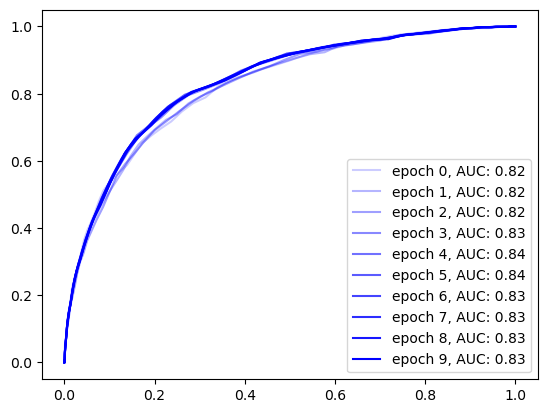

In [62]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Get priors
prior = torch.mean(y_train)
groups = torch.unique(income_train)
prior_groups = [torch.mean(y_train[income_train==group]) for group in groups]


# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.01
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in tqdm(range(10)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += 10*reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="prop1", value=prop_1, prior=prior)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

Seems to signigifantly impact performance without affecting the FDR equality. Now try Direct FDR regularisation

Loss: 0.650 | Reg: 0.105 | FDR Error Tr: 0.105 |  FDR Equal Error: 0.071 | Equality Error: 0.006 |  AUC: 0.810 | |FPR: 0.010 | TPR: 0.142 | FDR: 0.861
Loss: 0.430 | Reg: 0.016 | FDR Error Tr: 0.014 |  FDR Equal Error: 0.067 | Equality Error: 0.006 |  AUC: 0.838 | |FPR: 0.010 | TPR: 0.158 | FDR: 0.849
Loss: 0.513 | Reg: 0.019 | FDR Error Tr: 0.018 |  FDR Equal Error: 0.088 | Equality Error: 0.004 |  AUC: 0.836 | |FPR: 0.009 | TPR: 0.130 | FDR: 0.857
Loss: 0.479 | Reg: 0.099 | FDR Error Tr: 0.097 |  FDR Equal Error: 0.091 | Equality Error: 0.004 |  AUC: 0.840 | |FPR: 0.008 | TPR: 0.127 | FDR: 0.844
Loss: 0.450 | Reg: 0.083 | FDR Error Tr: 0.083 |  FDR Equal Error: 0.075 | Equality Error: 0.004 |  AUC: 0.844 | |FPR: 0.008 | TPR: 0.128 | FDR: 0.846
Loss: 0.520 | Reg: 0.063 | FDR Error Tr: 0.060 |  FDR Equal Error: 0.069 | Equality Error: 0.005 |  AUC: 0.845 | |FPR: 0.010 | TPR: 0.151 | FDR: 0.851
Loss: 0.495 | Reg: 0.088 | FDR Error Tr: 0.087 |  FDR Equal Error: 0.076 | Equality Error: 0.0

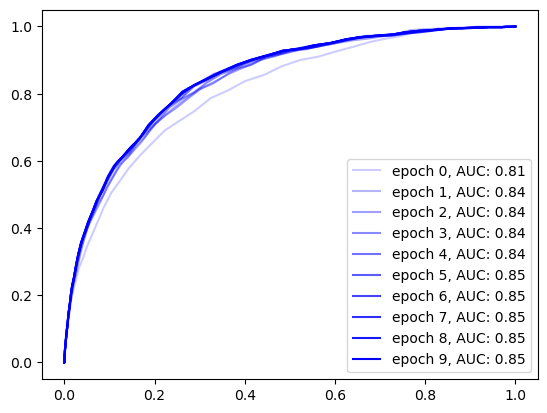

In [27]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Get priors
prior_tr = torch.mean(y_train)
groups = torch.unique(income_train)
prior_groups_tr = [torch.mean(y_train[income_train==group]) for group in groups]


# Set-up model
d = X_train.shape[1]
lossfunc = paired_aucloss
regularise = FDRRegPW(0.01, prior=prior_tr, prior_groups=prior_groups_tr, casttoprob=False)
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.01
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
preds0 = model.predict(x0).detach()
preds1 = model.predict(x1).detach()
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in range(10):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        equality_error_posttr = equality_loss_pw(preds0, preds1, income0, income1, regtype='fdr', 
                                             prior=prior_tr, prior_groups=prior_groups_tr)
        loss = lossfunc(scores0, scores1)
        loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        preds0 = model.predict(x0).detach()
        preds1 = model.predict(x1).detach()
        equality_error_tr = equality_loss_pw(preds0, preds1, income0, income1, regtype='fdr', 
                                             prior=prior_tr, prior_groups=prior_groups_tr)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="prop1", value=prop_1, prior=prior_tr)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | FDR Error Tr:{equality_error_tr.item(): .3f} | ",
              f"FDR Equal Error:{fdr_equal_error.item(): .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"AUC:{auc: .3f} | |FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}"
            )
    
ax.legend()
plt.show()

### All Class 1 Data

  2%|▏         | 1/50 [00:02<02:16,  2.79s/it]

Loss: 0.975 | Reg: 0.022 | FDR Error Tr: 0.022 |  AUC: 0.739 | Equality Error: 0.004 | FDR Equal Error: 0.068


 12%|█▏        | 6/50 [00:12<01:29,  2.04s/it]

Loss: 0.526 | Reg: 0.080 | FDR Error Tr: 0.080 |  AUC: 0.818 | Equality Error: 0.001 | FDR Equal Error: 0.143


 22%|██▏       | 11/50 [00:21<01:16,  1.95s/it]

Loss: 0.473 | Reg: 0.048 | FDR Error Tr: 0.047 |  AUC: 0.827 | Equality Error: 0.001 | FDR Equal Error: 0.096


 32%|███▏      | 16/50 [00:31<01:12,  2.13s/it]

Loss: 0.471 | Reg: 0.041 | FDR Error Tr: 0.041 |  AUC: 0.832 | Equality Error: 0.002 | FDR Equal Error: 0.082


 42%|████▏     | 21/50 [00:42<01:06,  2.29s/it]

Loss: 0.446 | Reg: 0.036 | FDR Error Tr: 0.035 |  AUC: 0.837 | Equality Error: 0.002 | FDR Equal Error: 0.085


 52%|█████▏    | 26/50 [00:53<00:55,  2.30s/it]

Loss: 0.456 | Reg: 0.050 | FDR Error Tr: 0.048 |  AUC: 0.839 | Equality Error: 0.002 | FDR Equal Error: 0.096


 62%|██████▏   | 31/50 [01:03<00:40,  2.13s/it]

Loss: 0.455 | Reg: 0.052 | FDR Error Tr: 0.052 |  AUC: 0.841 | Equality Error: 0.002 | FDR Equal Error: 0.098


 72%|███████▏  | 36/50 [01:13<00:29,  2.12s/it]

Loss: 0.444 | Reg: 0.043 | FDR Error Tr: 0.042 |  AUC: 0.841 | Equality Error: 0.002 | FDR Equal Error: 0.104


 82%|████████▏ | 41/50 [01:21<00:16,  1.79s/it]

Loss: 0.440 | Reg: 0.048 | FDR Error Tr: 0.048 |  AUC: 0.842 | Equality Error: 0.001 | FDR Equal Error: 0.107


 92%|█████████▏| 46/50 [01:29<00:06,  1.67s/it]

Loss: 0.440 | Reg: 0.052 | FDR Error Tr: 0.052 |  AUC: 0.842 | Equality Error: 0.001 | FDR Equal Error: 0.107


100%|██████████| 50/50 [01:35<00:00,  1.90s/it]


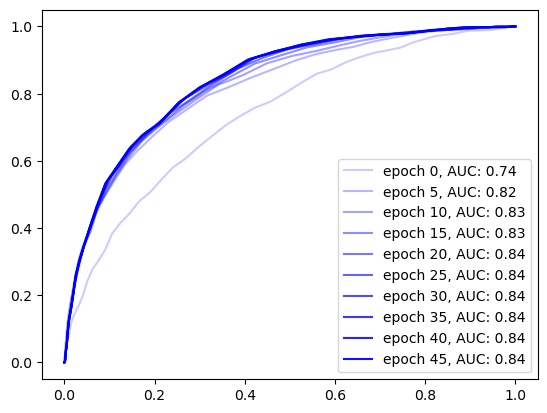

In [64]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = int(X_train1.shape[0])
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 50

# Get priors
prior_tr = torch.mean(y_train)
groups = torch.unique(income_train)
prior_groups_tr = [torch.mean(y_train[income_train==group]) for group in groups]


# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = FDRRegPW(0.01, prior=prior_tr, prior_groups=prior_groups_tr, casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.01
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
preds0 = model.predict(x0).detach()
preds1 = model.predict(x1).detach()
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in tqdm(range(nepochs)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        preds0 = model.predict(x0).detach()
        preds1 = model.predict(x1).detach()
        equality_error_tr = equality_loss_pw(preds0, preds1, income0, income1, regtype='fdr', 
                                             prior=prior_tr, prior_groups=prior_groups_tr)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    if epoch % 5 == 0:
        scheduler.step()
        with torch.no_grad():
            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            fpr, tpr = roc(scores_te, y_test)
            auc = AUC(fpr, tpr)
            single_fpr = FPR(pred_te, y_test)
            single_tpr = TPR(pred_te, y_test)
            single_fdr = FDR(pred_te, y_test)
            equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
            fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
            ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
            print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | FDR Error Tr:{equality_error_tr.item(): .3f} | ",
                f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
                #   f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}"
                )
        
ax.legend()
plt.show()

### Try higher Proportion

  2%|▏         | 1/50 [00:03<02:54,  3.56s/it]

Loss: 1.392 | Reg: 0.012 | FDR Error Tr: 0.012 |  AUC: 0.703 | Equality Error: 0.023 | FDR Equal Error: 0.023 FPR: 0.082 | TPR: 0.256 | FDR: 0.965


 12%|█▏        | 6/50 [00:17<02:04,  2.84s/it]

Loss: 0.478 | Reg: 0.038 | FDR Error Tr: 0.038 |  AUC: 0.816 | Equality Error: 0.021 | FDR Equal Error: 0.032 FPR: 0.068 | TPR: 0.433 | FDR: 0.931


 22%|██▏       | 11/50 [00:30<01:47,  2.75s/it]

Loss: 0.420 | Reg: 0.042 | FDR Error Tr: 0.043 |  AUC: 0.836 | Equality Error: 0.027 | FDR Equal Error: 0.030 FPR: 0.066 | TPR: 0.461 | FDR: 0.925


 32%|███▏      | 16/50 [00:44<01:35,  2.82s/it]

Loss: 0.395 | Reg: 0.039 | FDR Error Tr: 0.039 |  AUC: 0.843 | Equality Error: 0.027 | FDR Equal Error: 0.029 FPR: 0.065 | TPR: 0.461 | FDR: 0.925


 42%|████▏     | 21/50 [00:57<01:24,  2.93s/it]

Loss: 0.384 | Reg: 0.038 | FDR Error Tr: 0.039 |  AUC: 0.848 | Equality Error: 0.028 | FDR Equal Error: 0.030 FPR: 0.066 | TPR: 0.468 | FDR: 0.924


 52%|█████▏    | 26/50 [01:12<01:12,  3.01s/it]

Loss: 0.381 | Reg: 0.042 | FDR Error Tr: 0.043 |  AUC: 0.850 | Equality Error: 0.028 | FDR Equal Error: 0.031 FPR: 0.065 | TPR: 0.471 | FDR: 0.923


 62%|██████▏   | 31/50 [01:26<00:52,  2.77s/it]

Loss: 0.376 | Reg: 0.041 | FDR Error Tr: 0.041 |  AUC: 0.851 | Equality Error: 0.029 | FDR Equal Error: 0.030 FPR: 0.065 | TPR: 0.471 | FDR: 0.923


 72%|███████▏  | 36/50 [01:39<00:37,  2.69s/it]

Loss: 0.377 | Reg: 0.039 | FDR Error Tr: 0.039 |  AUC: 0.851 | Equality Error: 0.029 | FDR Equal Error: 0.031 FPR: 0.064 | TPR: 0.471 | FDR: 0.922


 82%|████████▏ | 41/50 [01:53<00:26,  2.95s/it]

Loss: 0.372 | Reg: 0.040 | FDR Error Tr: 0.040 |  AUC: 0.852 | Equality Error: 0.029 | FDR Equal Error: 0.030 FPR: 0.064 | TPR: 0.471 | FDR: 0.922


 92%|█████████▏| 46/50 [02:06<00:10,  2.73s/it]

Loss: 0.374 | Reg: 0.038 | FDR Error Tr: 0.038 |  AUC: 0.852 | Equality Error: 0.029 | FDR Equal Error: 0.030 FPR: 0.063 | TPR: 0.469 | FDR: 0.921


100%|██████████| 50/50 [02:16<00:00,  2.72s/it]


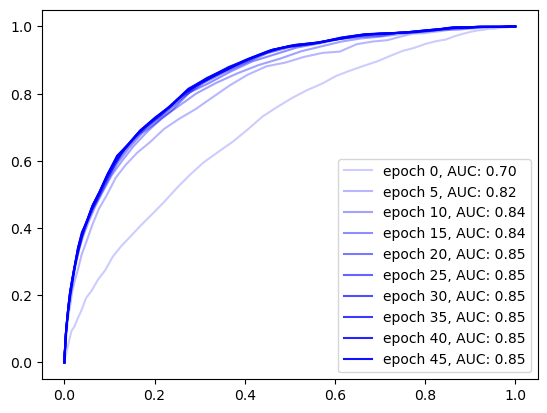

In [72]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = int(X_train1.shape[0])
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 50

# Get priors
prior_tr = torch.mean(y_train)
groups = torch.unique(income_train)
prior_groups_tr = [torch.mean(y_train[income_train==group]) for group in groups]


# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = FDRRegPW(0.01, prior=prior_tr, prior_groups=prior_groups_tr, casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.1
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
preds0 = model.predict(x0).detach()
preds1 = model.predict(x1).detach()
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in tqdm(range(nepochs)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        preds0 = model.predict(x0).detach()
        preds1 = model.predict(x1).detach()
        equality_error_tr = equality_loss_pw(preds0, preds1, income0, income1, regtype='fdr', 
                                             prior=prior_tr, prior_groups=prior_groups_tr)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    if epoch % 5 == 0:
        scheduler.step()
        with torch.no_grad():
            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            fpr, tpr = roc(scores_te, y_test)
            auc = AUC(fpr, tpr)
            single_fpr = FPR(pred_te, y_test)
            single_tpr = TPR(pred_te, y_test)
            single_fdr = FDR(pred_te, y_test)
            equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
            fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
            ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
            print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | FDR Error Tr:{equality_error_tr.item(): .3f} | ",
                f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
                f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}"
                )

ax.legend()
plt.show()

  2%|▏         | 1/50 [00:03<02:35,  3.17s/it]

Loss: 0.894 | Reg: 0.011 | FDR Error Tr: 0.011 |  AUC: 0.769 | Equality Error: 0.022 | FDR Equal Error: 0.026 FPR: 0.074 | TPR: 0.339 | FDR: 0.950


 12%|█▏        | 6/50 [00:17<02:18,  3.16s/it]

Loss: 0.514 | Reg: 0.036 | FDR Error Tr: 0.036 |  AUC: 0.818 | Equality Error: 0.028 | FDR Equal Error: 0.029 FPR: 0.067 | TPR: 0.448 | FDR: 0.928


 22%|██▏       | 11/50 [00:30<01:46,  2.74s/it]

Loss: 0.462 | Reg: 0.039 | FDR Error Tr: 0.039 |  AUC: 0.836 | Equality Error: 0.029 | FDR Equal Error: 0.031 FPR: 0.065 | TPR: 0.463 | FDR: 0.924


 32%|███▏      | 16/50 [00:43<01:33,  2.75s/it]

Loss: 0.437 | Reg: 0.036 | FDR Error Tr: 0.036 |  AUC: 0.843 | Equality Error: 0.029 | FDR Equal Error: 0.031 FPR: 0.065 | TPR: 0.465 | FDR: 0.924


 42%|████▏     | 21/50 [00:57<01:23,  2.88s/it]

Loss: 0.422 | Reg: 0.037 | FDR Error Tr: 0.037 |  AUC: 0.847 | Equality Error: 0.029 | FDR Equal Error: 0.029 FPR: 0.064 | TPR: 0.471 | FDR: 0.922


 52%|█████▏    | 26/50 [01:11<01:11,  2.99s/it]

Loss: 0.420 | Reg: 0.036 | FDR Error Tr: 0.036 |  AUC: 0.848 | Equality Error: 0.029 | FDR Equal Error: 0.027 FPR: 0.062 | TPR: 0.467 | FDR: 0.920


 62%|██████▏   | 31/50 [01:25<00:52,  2.79s/it]

Loss: 0.417 | Reg: 0.034 | FDR Error Tr: 0.034 |  AUC: 0.849 | Equality Error: 0.029 | FDR Equal Error: 0.028 FPR: 0.063 | TPR: 0.470 | FDR: 0.920


 72%|███████▏  | 36/50 [01:38<00:39,  2.80s/it]

Loss: 0.413 | Reg: 0.037 | FDR Error Tr: 0.037 |  AUC: 0.849 | Equality Error: 0.030 | FDR Equal Error: 0.028 FPR: 0.064 | TPR: 0.471 | FDR: 0.922


 82%|████████▏ | 41/50 [01:52<00:26,  2.98s/it]

Loss: 0.416 | Reg: 0.039 | FDR Error Tr: 0.039 |  AUC: 0.850 | Equality Error: 0.030 | FDR Equal Error: 0.028 FPR: 0.064 | TPR: 0.471 | FDR: 0.921


 92%|█████████▏| 46/50 [02:10<00:14,  3.58s/it]

Loss: 0.413 | Reg: 0.035 | FDR Error Tr: 0.035 |  AUC: 0.850 | Equality Error: 0.030 | FDR Equal Error: 0.028 FPR: 0.064 | TPR: 0.472 | FDR: 0.922


100%|██████████| 50/50 [02:23<00:00,  2.87s/it]


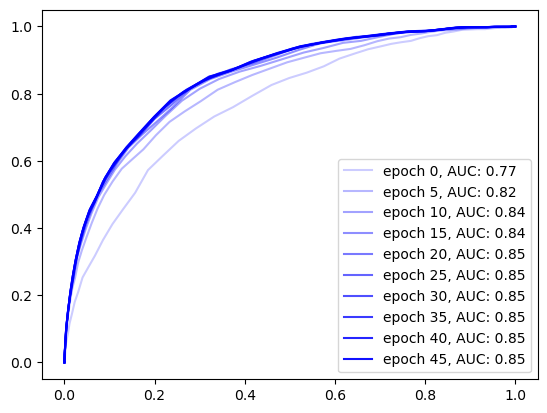

In [ ]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = int(X_train1.shape[0])
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 50

# Get priors
prior_tr = torch.mean(y_train)
groups = torch.unique(income_train)
prior_groups_tr = [torch.mean(y_train[income_train==group]) for group in groups]


# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = FDRRegPW(0.01, prior=prior_tr, prior_groups=prior_groups_tr, casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.1
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
preds0 = model.predict(x0).detach()
preds1 = model.predict(x1).detach()
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in tqdm(range(nepochs)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        preds0 = model.predict(x0).detach()
        preds1 = model.predict(x1).detach()
        equality_error_tr = equality_loss_pw(preds0, preds1, income0, income1, regtype='fdr', 
                                             prior=prior_tr, prior_groups=prior_groups_tr)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    if epoch % 5 == 0:
        scheduler.step()
        with torch.no_grad():
            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            fpr, tpr = roc(scores_te, y_test)
            auc = AUC(fpr, tpr)
            single_fpr = FPR(pred_te, y_test)
            single_tpr = TPR(pred_te, y_test)
            single_fdr = FDR(pred_te, y_test)
            equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
            fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
            ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
            print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | FDR Error Tr:{equality_error_tr.item(): .3f} | ",
                f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
                f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}"
                )

ax.legend()
plt.show()

Loss: 0.918 | Reg: 0.011 | FDR Error Tr: 0.011 |  FDR Equal Error: 0.024 | AUC: 0.764 | FPR: 0.073 | TPR: 0.353 | FDR: 0.947
Loss: 0.591 | Reg: 0.034 | FDR Error Tr: 0.034 |  FDR Equal Error: 0.030 | AUC: 0.817 | FPR: 0.068 | TPR: 0.432 | FDR: 0.932
Loss: 0.565 | Reg: 0.032 | FDR Error Tr: 0.032 |  FDR Equal Error: 0.033 | AUC: 0.826 | FPR: 0.064 | TPR: 0.447 | FDR: 0.926
Loss: 0.569 | Reg: 0.038 | FDR Error Tr: 0.038 |  FDR Equal Error: 0.030 | AUC: 0.828 | FPR: 0.065 | TPR: 0.466 | FDR: 0.923
Loss: 0.586 | Reg: 0.036 | FDR Error Tr: 0.036 |  FDR Equal Error: 0.030 | AUC: 0.827 | FPR: 0.065 | TPR: 0.463 | FDR: 0.924
Loss: 0.590 | Reg: 0.036 | FDR Error Tr: 0.036 |  FDR Equal Error: 0.030 | AUC: 0.826 | FPR: 0.066 | TPR: 0.468 | FDR: 0.925
Loss: 0.594 | Reg: 0.036 | FDR Error Tr: 0.036 |  FDR Equal Error: 0.030 | AUC: 0.825 | FPR: 0.065 | TPR: 0.461 | FDR: 0.925
Loss: 0.594 | Reg: 0.036 | FDR Error Tr: 0.036 |  FDR Equal Error: 0.031 | AUC: 0.825 | FPR: 0.064 | TPR: 0.457 | FDR: 0.924


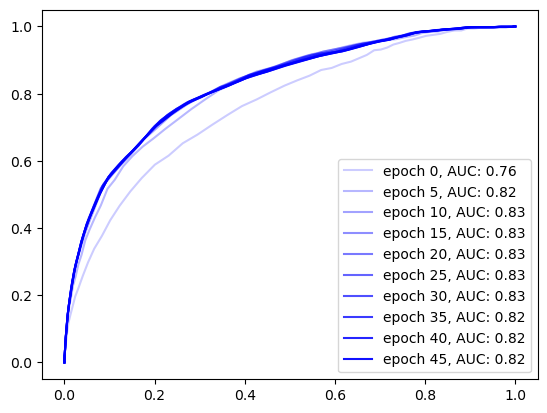

In [26]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = int(X_train1.shape[0])
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 50

# Get priors
prior_tr = torch.mean(y_train)
groups = torch.unique(income_train)
prior_groups_tr = [torch.mean(y_train[income_train==group]) for group in groups]


# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = FDRRegPW(0.01, prior=prior_tr, prior_groups=prior_groups_tr, casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.1
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
preds0 = model.predict(x0).detach()
preds1 = model.predict(x1).detach()
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in range(nepochs):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += 3*reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        preds0 = model.predict(x0).detach()
        preds1 = model.predict(x1).detach()
        equality_error_tr = equality_loss_pw(preds0, preds1, income0, income1, regtype='fdr', 
                                             prior=prior_tr, prior_groups=prior_groups_tr)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    if epoch % 5 == 0:
        scheduler.step()
        with torch.no_grad():
            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            fpr, tpr = roc(scores_te, y_test)
            auc = AUC(fpr, tpr)
            single_fpr = FPR(pred_te, y_test)
            single_tpr = TPR(pred_te, y_test)
            single_fdr = FDR(pred_te, y_test)
            equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
            fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
            ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
            print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | FDR Error Tr:{equality_error_tr.item(): .3f} | ",
                  f"FDR Equal Error:{fdr_equal_error.item(): .3f} |",
                  f"AUC:{auc: .3f} | FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}"
                )

ax.legend()
plt.show()

No seeming improvement for FDR here.

## Multiple Experiments

In [90]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10
# Set-up model
d = X_train.shape[1]


# Get priors
prior_tr = torch.mean(y_train)
groups = torch.unique(income_train)
prior_groups_tr = [torch.mean(y_train[income_train==group]) for group in groups]

lossfunc = paired_aucloss
tau = 0
regularise = FDRRegPW(0.01, prior=prior_tr, prior_groups=prior_groups_tr, casttoprob=False)
prop_1 = 0.01

equal_losses = []
aucs = []
rocs = []
single_tprs = []
equal_losses_logit = []
lambs = [0.,0.5,1.,1.5,2.]
nrep = 10
for lamb in tqdm(lambs):
    for j in range(nrep):
        # Set-up model
        model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
        # Train model
        (x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 20% FP rate
        update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1, prior=prior_tr)
        scores1 = scores1.repeat(batch_rep)
        for epoch in range(10):
            for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
                optimizer.zero_grad()
                loss = lossfunc(scores0, scores1)
                loss += lamb*reg
                loss.backward()
                optimizer.step()
                scores0 = model(x0).squeeze()
                scores1 = model(x1).squeeze()
                reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
                # Use 0 scores to update tau to give 25% FP rate
                update_tau(model, scores0.detach(), scores1.detach(),
                           type="prop1", value=prop_1, prior=prior_tr)
                # upscale scores to be same length as scores0
                scores1 = scores1.repeat(batch_rep)
            scheduler.step()
        with torch.no_grad():
            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            # Get Odd loss 
            equal_loss = equality_loss(y_test, pred_te, income_test, regtype='fdr').item()
            equal_loss_logit = equality_loss(y_test, pred_te, income_test, regtype='fdr', logit=True).item()
            single_fpr = FPR(pred_te, y_test)
            single_tpr = TPR(pred_te, y_test)
            equal_losses.append(equal_loss)
            equal_losses_logit.append(equal_loss_logit)
            fpr, tpr = roc(scores_te, y_test)
            rocs.append([fpr, tpr])
            auc = AUC(fpr, tpr)
            aucs.append(auc)
            single_tprs.append(single_tpr.item())
        del model

result_dict = {'equal_losses': equal_losses, 'aucs': aucs, 'rocs': rocs, 
               "single_tprs": single_tprs, "equal_losses_logit": equal_losses_logit}

result_dict_tensor = {key: torch.tensor(value) for key, value in result_dict.items()}
result_dict_tensor = {key: value.reshape(len(lambs), nrep, *value[0,...].shape) 
                      for key, value in result_dict_tensor.items()}

torch.save(result_dict_tensor | {"lambdas": lambs},
           'AUC_FDR_results.pt')

100%|██████████| 5/5 [09:21<00:00, 112.37s/it]


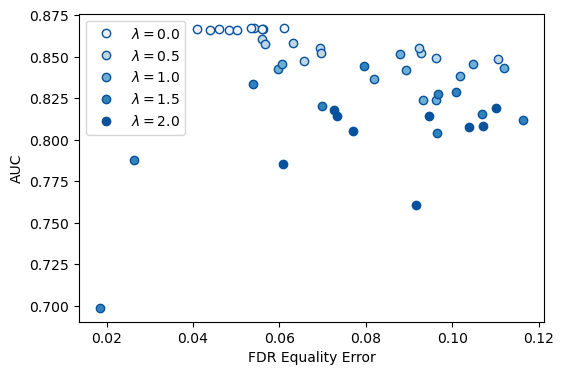

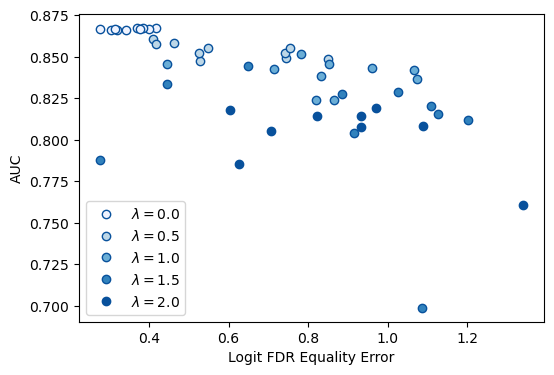

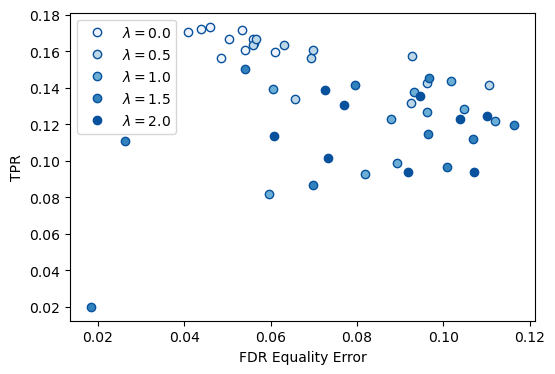

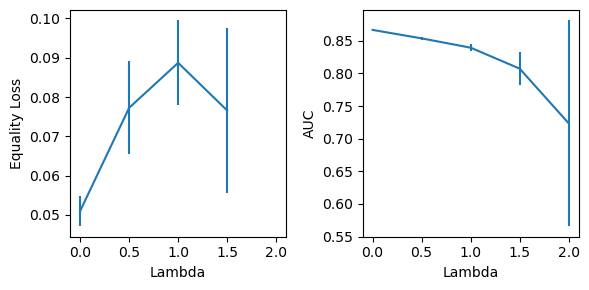

In [21]:

results = torch.load('AUC_FDR_results.pt')
equal_losses, aucs, rocs, equal_losses_logit, single_tprs, lambs = [
    results[key] for key in ["equal_losses", "aucs", "rocs", "equal_losses_logit", "single_tprs", "lambdas"]]
nrep=int(equal_losses.shape[1])
alphas = torch.linspace(0.2, 1, len(lambs))
lambda_cols = ["#eff3ff", "#bdd7e7", "#6baed6", "#3182bd", "#08519c"]
fig, ax = plt.subplots(figsize=(6,4))
for i,lamb in enumerate(lambs):
    ax.plot(equal_losses[i], aucs[i], 'o', label = r"$\lambda=$"+f'{lamb}', color=lambda_cols[i],markeredgecolor='#08519c')
ax.set_xlabel('FDR Equality Error')
ax.set_ylabel('AUC')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
for i,lamb in enumerate(lambs):
    ax.plot(equal_losses_logit[i], aucs[i], 'o', label = r"$\lambda=$"+f'{lamb}', color=lambda_cols[i],markeredgecolor='#08519c')
ax.set_xlabel('Logit FDR Equality Error')
ax.set_ylabel('AUC')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
for i,lamb in enumerate(lambs):
    ax.plot(equal_losses[i], single_tprs[i], 'o', label = r"$\lambda=$"+f'{lamb}', color=lambda_cols[i],markeredgecolor='#08519c')
ax.set_xlabel('FDR Equality Error')
ax.set_ylabel('TPR')
ax.legend()
fig, ax = plt.subplots(ncols=2, figsize=(6,3))
ax[0].errorbar(lambs, torch.mean(equal_losses, dim=1), yerr=1.96*torch.std(equal_losses, dim=1)/nrep**0.5, label = 'Mean Equal Loss')
ax[0].set_xlabel('Lambda')
ax[0].set_ylabel('Equality Loss')
ax[1].errorbar(lambs, torch.mean(aucs, dim=1), yerr=1.96*torch.std(aucs, dim=1)/nrep**0.5, label = 'Mean AUC')
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('AUC')
fig.tight_layout()


## Test regularisation

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.0053)
tensor(0.0053)


  2%|▏         | 1/50 [00:05<04:13,  5.17s/it]

Loss: 0.901 | Reg: 0.017 | FDR Error Tr: 0.017 |  AUC: 0.754 | Equality Error: 0.003 | FDR Equal Error: 0.100


 10%|█         | 5/50 [00:21<03:03,  4.08s/it]

tensor(0.1225)
tensor(0.1225)


 12%|█▏        | 6/50 [00:26<03:11,  4.34s/it]

Loss: 0.640 | Reg: 0.067 | FDR Error Tr: 0.067 |  AUC: 0.793 | Equality Error: 0.003 | FDR Equal Error: 0.086


 20%|██        | 10/50 [00:42<02:41,  4.04s/it]

tensor(0.0993)
tensor(0.0993)


 22%|██▏       | 11/50 [00:46<02:42,  4.18s/it]

Loss: 0.619 | Reg: 0.081 | FDR Error Tr: 0.081 |  AUC: 0.807 | Equality Error: 0.002 | FDR Equal Error: 0.117


 30%|███       | 15/50 [01:02<02:17,  3.93s/it]

tensor(0.0608)
tensor(0.0608)


 32%|███▏      | 16/50 [01:07<02:26,  4.31s/it]

Loss: 0.586 | Reg: 0.084 | FDR Error Tr: 0.086 |  AUC: 0.815 | Equality Error: 0.002 | FDR Equal Error: 0.116


 40%|████      | 20/50 [01:22<02:00,  4.03s/it]

tensor(0.0672)
tensor(0.0672)


 42%|████▏     | 21/50 [01:27<02:01,  4.19s/it]

Loss: 0.603 | Reg: 0.069 | FDR Error Tr: 0.068 |  AUC: 0.817 | Equality Error: 0.002 | FDR Equal Error: 0.121


 50%|█████     | 25/50 [01:44<01:41,  4.07s/it]

tensor(0.0361)
tensor(0.0361)


 52%|█████▏    | 26/50 [01:48<01:40,  4.20s/it]

Loss: 0.556 | Reg: 0.075 | FDR Error Tr: 0.074 |  AUC: 0.817 | Equality Error: 0.002 | FDR Equal Error: 0.120


 60%|██████    | 30/50 [02:04<01:20,  4.01s/it]

tensor(0.0550)
tensor(0.0550)


 62%|██████▏   | 31/50 [02:08<01:19,  4.18s/it]

Loss: 0.553 | Reg: 0.066 | FDR Error Tr: 0.066 |  AUC: 0.817 | Equality Error: 0.002 | FDR Equal Error: 0.120


 70%|███████   | 35/50 [02:28<01:12,  4.83s/it]

tensor(0.1121)
tensor(0.1121)


 72%|███████▏  | 36/50 [02:34<01:13,  5.28s/it]

Loss: 0.602 | Reg: 0.071 | FDR Error Tr: 0.070 |  AUC: 0.817 | Equality Error: 0.002 | FDR Equal Error: 0.123


 80%|████████  | 40/50 [02:52<00:45,  4.53s/it]

tensor(0.0820)
tensor(0.0820)


 82%|████████▏ | 41/50 [02:56<00:40,  4.53s/it]

Loss: 0.588 | Reg: 0.090 | FDR Error Tr: 0.090 |  AUC: 0.817 | Equality Error: 0.002 | FDR Equal Error: 0.123


 90%|█████████ | 45/50 [03:13<00:21,  4.21s/it]

tensor(0.1184)
tensor(0.1184)


 92%|█████████▏| 46/50 [03:17<00:17,  4.32s/it]

Loss: 0.563 | Reg: 0.072 | FDR Error Tr: 0.074 |  AUC: 0.817 | Equality Error: 0.002 | FDR Equal Error: 0.120


100%|██████████| 50/50 [03:34<00:00,  4.29s/it]


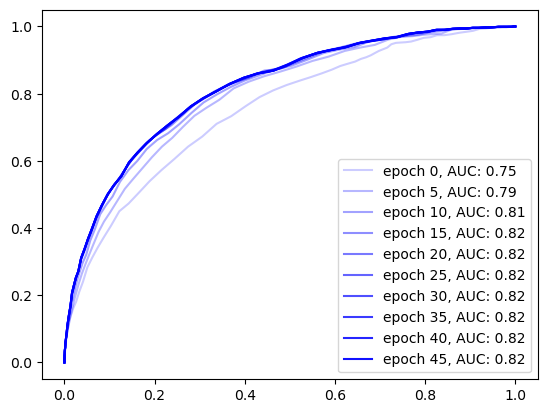

In [67]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1)
shared_data = TensorDataset(X_train, y_train, income_train)
small_batch = int(X_train1.shape[0])
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
shared_data_loader = DataLoader(shared_data, batch_size = large_batch, shuffle = True, drop_last=True)
nepochs = 50

# Get priors
prior_tr = torch.mean(y_train)
groups = torch.unique(income_train)
prior_groups_tr = [torch.mean(y_train[income_train==group]) for group in groups]


# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = FDRRegPW(0.01, prior=prior_tr, prior_groups=prior_groups_tr, casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.01
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
preds0 = model.predict(x0).detach()
preds1 = model.predict(x1).detach()
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in tqdm(range(nepochs)):
    for (x0, income0), (x1, income1), (x_all, y_all, income_all) in zip(dataloader0, dataloader1, shared_data_loader):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        preds0 = model.predict(x0).detach()
        preds1 = model.predict(x1).detach()
        equality_error_tr = equality_loss_pw(preds0, preds1, income0, income1, regtype='fdr', 
                                             prior=prior_tr, prior_groups=prior_groups_tr)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    if epoch % 5 == 0:
        scheduler.step()
        with torch.no_grad():

            pred_tr_all = model.predict(x_all).squeeze()
            print(equality_loss(y_all, pred_tr_all, income_all, regtype='fdr'))
            # Split
            pred_tr_0 = pred_tr_all[y_all==0.]
            income_tr_0 = income_all[y_all==0.]
            pred_tr_1 = pred_tr_all[y_all==1.]
            income_tr_1 = income_all[y_all==1.]
            prior_all = torch.mean(y_all)
            prior_groups_all = [torch.mean(y_all[income_all==group]) for group in groups]
            print(equality_loss_pw(pred_tr_0, pred_tr_1, income_tr_0, income_tr_1, regtype='fdr', prior = prior_all, prior_groups=prior_groups_all))

            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            fpr, tpr = roc(scores_te, y_test)
            auc = AUC(fpr, tpr)
            single_fpr = FPR(pred_te, y_test)
            single_tpr = TPR(pred_te, y_test)
            single_fdr = FDR(pred_te, y_test)
            equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
            fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
            ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
            print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | FDR Error Tr:{equality_error_tr.item(): .3f} | ",
                f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
                #   f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}"
                )
        
ax.legend()
plt.show()

tensor(0.0544)
tensor(0.0544)
Loss: 0.775 | Reg: 0.015 | FDR Error Tr: 0.015 |  AUC: 0.743 | Equality Error: 0.004 | FDR Equal Error: 0.043
tensor(0.0626)
tensor(0.0626)
Loss: 0.556 | Reg: 0.051 | FDR Error Tr: 0.051 |  AUC: 0.808 | Equality Error: 0.005 | FDR Equal Error: 0.092
tensor(0.0647)
tensor(0.0647)
Loss: 0.547 | Reg: 0.065 | FDR Error Tr: 0.065 |  AUC: 0.821 | Equality Error: 0.004 | FDR Equal Error: 0.123
tensor(0.0632)
tensor(0.0632)
Loss: 0.528 | Reg: 0.069 | FDR Error Tr: 0.069 |  AUC: 0.828 | Equality Error: 0.004 | FDR Equal Error: 0.108
tensor(0.0647)
tensor(0.0647)
Loss: 0.518 | Reg: 0.065 | FDR Error Tr: 0.064 |  AUC: 0.831 | Equality Error: 0.004 | FDR Equal Error: 0.113
tensor(0.0626)
tensor(0.0626)
Loss: 0.504 | Reg: 0.065 | FDR Error Tr: 0.065 |  AUC: 0.832 | Equality Error: 0.004 | FDR Equal Error: 0.118
tensor(0.0605)
tensor(0.0605)
Loss: 0.500 | Reg: 0.061 | FDR Error Tr: 0.060 |  AUC: 0.834 | Equality Error: 0.004 | FDR Equal Error: 0.123
tensor(0.0609)
tenso

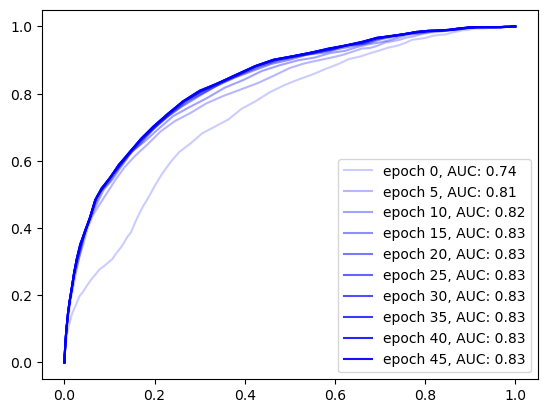

In [70]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1)
small_batch = int(X_train1.shape[0])
batch_rep = 50
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 50

# Get priors
prior_tr = torch.mean(y_train)
groups = torch.unique(income_train)
prior_groups_tr = [torch.mean(y_train[income_train==group]) for group in groups]


# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = FDRRegPW(0.01, prior=prior_tr, prior_groups=prior_groups_tr, casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.01
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
preds0 = model.predict(x0).detach()
preds1 = model.predict(x1).detach()
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in range(nepochs):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        preds0 = model.predict(x0).detach()
        preds1 = model.predict(x1).detach()
        equality_error_tr = equality_loss_pw(preds0, preds1, income0, income1, regtype='fdr', 
                                             prior=prior_tr, prior_groups=prior_groups_tr)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    if epoch % 5 == 0:
        scheduler.step()
        with torch.no_grad():

            pred_train = model.predict(X_train).squeeze()
            print(equality_loss(y_train, pred_train, income_train, regtype='fdr'))
            # Split
            pred_tr_0 = pred_train[y_train==0.]
            income_tr_0 = income_train[y_train==0.]
            pred_tr_1 = pred_train[y_train==1.]
            income_tr_1 = income_train[y_train==1.]
            prior_train = torch.mean(y_train)
            prior_groups_train = [torch.mean(y_train[income_train==group]) for group in groups]
            print(equality_loss_pw(pred_tr_0, pred_tr_1, income_tr_0, income_tr_1, regtype='fdr', prior = prior_train, prior_groups=prior_groups_train))

            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            fpr, tpr = roc(scores_te, y_test)
            auc = AUC(fpr, tpr)
            single_fpr = FPR(pred_te, y_test)
            single_tpr = TPR(pred_te, y_test)
            single_fdr = FDR(pred_te, y_test)
            equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
            fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
            ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
            print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | FDR Error Tr:{equality_error_tr.item(): .3f} | ",
                f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
                #   f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}"
                )
        
ax.legend()
plt.show()

### Fixed FDR

 10%|█         | 1/10 [00:01<00:17,  1.96s/it]

Loss: 0.516 | Reg: 0.002 |  AUC: 0.839 | Equality Error: 0.001 | FDR Equal Error: 0.130 FPR: 0.003 | TPR: 0.059 | FDR: 0.817


 20%|██        | 2/10 [00:03<00:14,  1.87s/it]

Loss: 0.406 | Reg: 0.001 |  AUC: 0.861 | Equality Error: 0.000 | FDR Equal Error: 0.228 FPR: 0.001 | TPR: 0.026 | FDR: 0.748


 30%|███       | 3/10 [00:05<00:13,  1.93s/it]

Loss: 0.369 | Reg: 0.002 |  AUC: 0.864 | Equality Error: 0.002 | FDR Equal Error: 0.162 FPR: 0.002 | TPR: 0.064 | FDR: 0.741


 40%|████      | 4/10 [00:08<00:13,  2.22s/it]

Loss: 0.374 | Reg: 0.001 |  AUC: 0.865 | Equality Error: 0.002 | FDR Equal Error: 0.132 FPR: 0.003 | TPR: 0.079 | FDR: 0.754


 50%|█████     | 5/10 [00:11<00:11,  2.40s/it]

Loss: 0.352 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.002 | FDR Equal Error: 0.138 FPR: 0.002 | TPR: 0.070 | FDR: 0.750


 60%|██████    | 6/10 [00:13<00:09,  2.45s/it]

Loss: 0.368 | Reg: 0.002 |  AUC: 0.866 | Equality Error: 0.002 | FDR Equal Error: 0.117 FPR: 0.003 | TPR: 0.081 | FDR: 0.746


 70%|███████   | 7/10 [00:15<00:07,  2.40s/it]

Loss: 0.364 | Reg: 0.002 |  AUC: 0.866 | Equality Error: 0.002 | FDR Equal Error: 0.083 FPR: 0.003 | TPR: 0.091 | FDR: 0.755


 80%|████████  | 8/10 [00:18<00:04,  2.37s/it]

Loss: 0.342 | Reg: 0.002 |  AUC: 0.866 | Equality Error: 0.002 | FDR Equal Error: 0.133 FPR: 0.002 | TPR: 0.071 | FDR: 0.745


 90%|█████████ | 9/10 [00:20<00:02,  2.35s/it]

Loss: 0.357 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.002 | FDR Equal Error: 0.128 FPR: 0.002 | TPR: 0.070 | FDR: 0.743


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]

Loss: 0.375 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.002 | FDR Equal Error: 0.118 FPR: 0.003 | TPR: 0.077 | FDR: 0.748


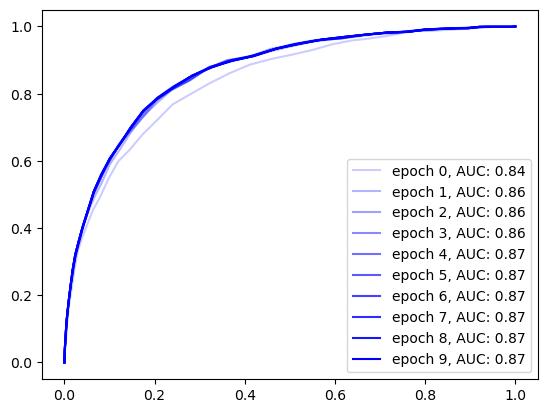

In [30]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.01
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
update_tau(model, scores0, scores1, type="prop1", value=prop_1)
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in tqdm(range(10)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0, scores1,
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    scores = torch.sigmoid(model(X_train).detach().squeeze())
    prop_1 = fdr_score_prop1(scores, y_train, 0.8)
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

Here the FDR equality error is over 10 times larger than the equality error. We see if normal regularisation helps this

 10%|█         | 1/10 [00:01<00:15,  1.71s/it]

Loss: 0.732 | Reg: 0.002 |  AUC: 0.769 | Equality Error: 0.001 | FDR Equal Error: 0.113 FPR: 0.005 | TPR: 0.066 | FDR: 0.863


 20%|██        | 2/10 [00:03<00:13,  1.71s/it]

Loss: 0.468 | Reg: 0.000 |  AUC: 0.822 | Equality Error: 0.000 | FDR Equal Error: 0.500 FPR: 0.000 | TPR: 0.002 | FDR: 0.714


 30%|███       | 3/10 [00:05<00:12,  1.73s/it]

Loss: 0.441 | Reg: 0.001 |  AUC: 0.836 | Equality Error: 0.000 | FDR Equal Error: 0.140 FPR: 0.001 | TPR: 0.018 | FDR: 0.798


 40%|████      | 4/10 [00:07<00:11,  1.84s/it]

Loss: 0.423 | Reg: 0.001 |  AUC: 0.841 | Equality Error: 0.001 | FDR Equal Error: 0.178 FPR: 0.001 | TPR: 0.041 | FDR: 0.750


 50%|█████     | 5/10 [00:09<00:10,  2.00s/it]

Loss: 0.396 | Reg: 0.001 |  AUC: 0.843 | Equality Error: 0.001 | FDR Equal Error: 0.135 FPR: 0.002 | TPR: 0.046 | FDR: 0.753


 60%|██████    | 6/10 [00:12<00:08,  2.20s/it]

Loss: 0.393 | Reg: 0.001 |  AUC: 0.844 | Equality Error: 0.001 | FDR Equal Error: 0.127 FPR: 0.002 | TPR: 0.058 | FDR: 0.744


 70%|███████   | 7/10 [00:14<00:06,  2.31s/it]

Loss: 0.405 | Reg: 0.001 |  AUC: 0.845 | Equality Error: 0.001 | FDR Equal Error: 0.139 FPR: 0.002 | TPR: 0.055 | FDR: 0.749


 80%|████████  | 8/10 [00:16<00:04,  2.32s/it]

Loss: 0.385 | Reg: 0.000 |  AUC: 0.845 | Equality Error: 0.001 | FDR Equal Error: 0.129 FPR: 0.002 | TPR: 0.058 | FDR: 0.747


 90%|█████████ | 9/10 [00:19<00:02,  2.28s/it]

Loss: 0.417 | Reg: 0.002 |  AUC: 0.845 | Equality Error: 0.001 | FDR Equal Error: 0.142 FPR: 0.001 | TPR: 0.040 | FDR: 0.747


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

Loss: 0.383 | Reg: 0.001 |  AUC: 0.845 | Equality Error: 0.001 | FDR Equal Error: 0.154 FPR: 0.002 | TPR: 0.053 | FDR: 0.749


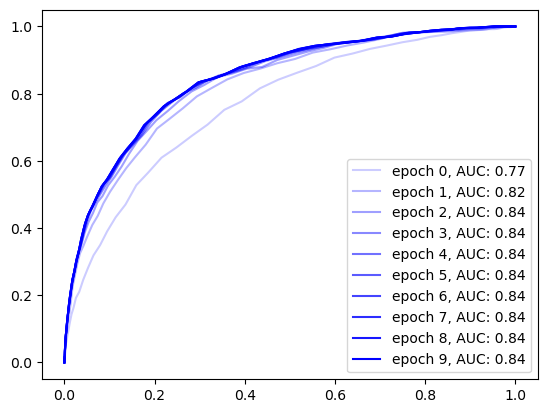

In [32]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.01
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in tqdm(range(10)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += 10*reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    scores = torch.sigmoid(model(X_train)).detach().squeeze()
    prop_1 = fdr_score_prop1(scores, y_train, 0.8)
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

Now try Direct FDR regularisation

 10%|█         | 1/10 [00:02<00:18,  2.01s/it]

Loss: 0.734 | FDR Tr: 0.411 | Reg: 0.171 | FDR Error Tr: 0.173 |  AUC: 0.819 | Equality Error: 0.002 | FDR Equal Error: 0.136 FPR: 0.004 | TPR: 0.071 | FDR: 0.813


 20%|██        | 2/10 [00:03<00:15,  1.93s/it]

Loss: 0.574 | FDR Tr: 0.254 | Reg: 0.312 | FDR Error Tr: 0.282 |  AUC: 0.832 | Equality Error: 0.001 | FDR Equal Error: 0.253 FPR: 0.001 | TPR: 0.040 | FDR: 0.732


 30%|███       | 3/10 [00:06<00:14,  2.08s/it]

Loss: 0.671 | FDR Tr: 0.343 | Reg: 0.183 | FDR Error Tr: 0.204 |  AUC: 0.830 | Equality Error: 0.001 | FDR Equal Error: 0.263 FPR: 0.001 | TPR: 0.040 | FDR: 0.728


 40%|████      | 4/10 [00:08<00:12,  2.01s/it]

Loss: 0.728 | FDR Tr: 0.306 | Reg: 0.349 | FDR Error Tr: 0.381 |  AUC: 0.834 | Equality Error: 0.001 | FDR Equal Error: 0.231 FPR: 0.002 | TPR: 0.041 | FDR: 0.762


 50%|█████     | 5/10 [00:10<00:10,  2.08s/it]

Loss: 0.599 | FDR Tr: 0.424 | Reg: 0.251 | FDR Error Tr: 0.296 |  AUC: 0.836 | Equality Error: 0.001 | FDR Equal Error: 0.222 FPR: 0.001 | TPR: 0.038 | FDR: 0.765


 60%|██████    | 6/10 [00:12<00:08,  2.08s/it]

Loss: 0.480 | FDR Tr: 0.385 | Reg: 0.265 | FDR Error Tr: 0.319 |  AUC: 0.837 | Equality Error: 0.001 | FDR Equal Error: 0.192 FPR: 0.001 | TPR: 0.029 | FDR: 0.748


 70%|███████   | 7/10 [00:14<00:06,  2.13s/it]

Loss: 0.485 | FDR Tr: 0.236 | Reg: 0.094 | FDR Error Tr: 0.093 |  AUC: 0.837 | Equality Error: 0.001 | FDR Equal Error: 0.192 FPR: 0.001 | TPR: 0.029 | FDR: 0.748


 80%|████████  | 8/10 [00:16<00:04,  2.09s/it]

Loss: 0.527 | FDR Tr: 0.214 | Reg: 0.220 | FDR Error Tr: 0.226 |  AUC: 0.837 | Equality Error: 0.001 | FDR Equal Error: 0.214 FPR: 0.001 | TPR: 0.032 | FDR: 0.748


 90%|█████████ | 9/10 [00:18<00:02,  2.04s/it]

Loss: 0.558 | FDR Tr: 0.288 | Reg: 0.255 | FDR Error Tr: 0.239 |  AUC: 0.837 | Equality Error: 0.001 | FDR Equal Error: 0.234 FPR: 0.001 | TPR: 0.036 | FDR: 0.752


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

Loss: 0.655 | FDR Tr: 0.260 | Reg: 0.297 | FDR Error Tr: 0.295 |  AUC: 0.837 | Equality Error: 0.001 | FDR Equal Error: 0.220 FPR: 0.001 | TPR: 0.034 | FDR: 0.750


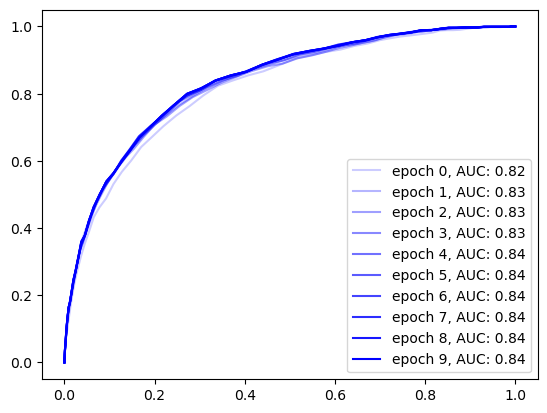

In [36]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = FDRRegPW(0.1, casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.01
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
for epoch in tqdm(range(10)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Get predictions from this round.
        pred_temp = torch.cat(((scores0>model.tau).float(), (scores1>model.tau).float()))
        labels_temp = torch.cat((torch.zeros_like(scores0),torch.ones_like(scores1)))
        equality_error_tr = equality_loss(
            labels_temp, pred_temp, torch.cat((income0, income1)), regtype='fdr')
        fdr_tr = FDR(pred_temp, labels_temp)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(),
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    scores = torch.sigmoid(model(X_train)).detach().squeeze()
    prop_1 = fdr_score_prop1(scores, y_train, 0.8)
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | FDR Tr:{fdr_tr.item(): .3f} | Reg:{reg.item(): .3f} | FDR Error Tr:{equality_error_tr.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
    
ax.legend()
plt.show()

Essentialy with so few points classified as 1 at each point the FDR is difficult to approximate. Try with a larger batch size.

### Test Regularisation

Loss: 1.208 | Reg: 0.168 | FDR Error Tr: 0.222 |  AUC: 0.695 | Equality Error: 0.004 | FDR Equal Error: 0.049 FPR: 0.007 | TPR: 0.046 | FDR: 0.933
Loss: 0.875 | Reg: 0.093 | FDR Error Tr: 0.093 |  AUC: 0.756 | Equality Error: 0.002 | FDR Equal Error: 0.061 FPR: 0.005 | TPR: 0.050 | FDR: 0.892
Loss: 0.729 | Reg: 0.144 | FDR Error Tr: 0.145 |  AUC: 0.772 | Equality Error: 0.001 | FDR Equal Error: 0.107 FPR: 0.004 | TPR: 0.063 | FDR: 0.852
Loss: 0.710 | Reg: 0.077 | FDR Error Tr: 0.067 |  AUC: 0.780 | Equality Error: 0.002 | FDR Equal Error: 0.107 FPR: 0.004 | TPR: 0.059 | FDR: 0.848
Loss: 0.699 | Reg: 0.197 | FDR Error Tr: 0.210 |  AUC: 0.788 | Equality Error: 0.002 | FDR Equal Error: 0.108 FPR: 0.004 | TPR: 0.064 | FDR: 0.840
Loss: 0.798 | Reg: 0.250 | FDR Error Tr: 0.247 |  AUC: 0.793 | Equality Error: 0.002 | FDR Equal Error: 0.111 FPR: 0.004 | TPR: 0.066 | FDR: 0.827
Loss: 0.913 | Reg: 0.054 | FDR Error Tr: 0.051 |  AUC: 0.797 | Equality Error: 0.002 | FDR Equal Error: 0.116 FPR: 0.0

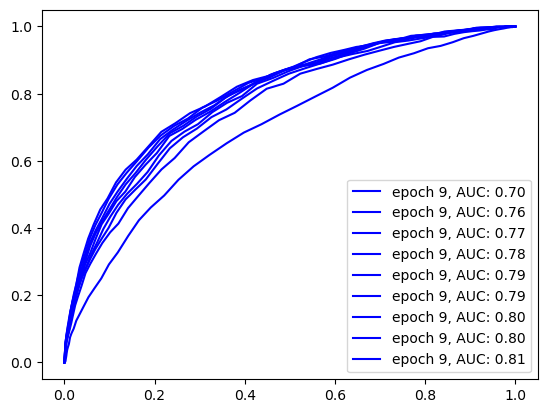

In [35]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)
nepochs = 10

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = FDRRegPW(0.1, casttoprob=False)
alphas = torch.linspace(0.2, 1, nepochs)



fig,ax = plt.subplots()
# Train model
# set-up initial scores
prop_1 = 0.01
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
update_tau(model, scores0.detach(), scores1.detach(), type="prop1", value=prop_1)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate

for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
    optimizer.zero_grad()
    loss = lossfunc(scores0, scores1)
    loss += reg
    loss.backward()
    optimizer.step()
    scores0 = model(x0).squeeze()
    scores1 = model(x1).squeeze()
    reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
    equality_error_tr = equality_loss(
        torch.cat((torch.zeros(scores0.shape[0]),torch.ones(scores1.shape[0]))), 
        torch.cat(((scores0>model.tau).float(), (scores1>model.tau).float())),
        torch.cat((income0, income1)), regtype='fdr')
    # Use 0 scores to update tau to give 25% FP rate
    update_tau(model, scores0.detach(), scores1.detach(),
                type="prop1", value=prop_1)
    # upscale scores to be same length as scores0
    scores1 = scores1.repeat(batch_rep)
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        fdr_equal_error = equality_loss(y_test, pred_te, income_test, regtype="fdr")
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | FDR Error Tr:{equality_error_tr.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | FDR Equal Error:{fdr_equal_error.item(): .3f}",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

# All Methods

## TP=0.2

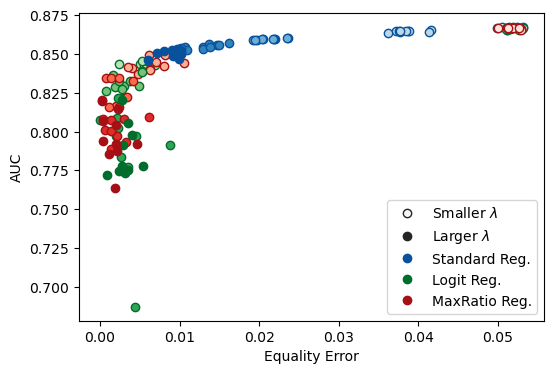

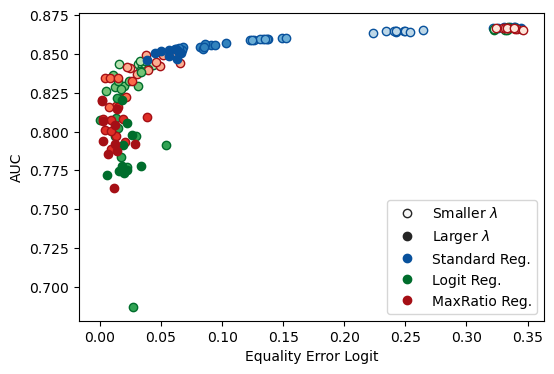

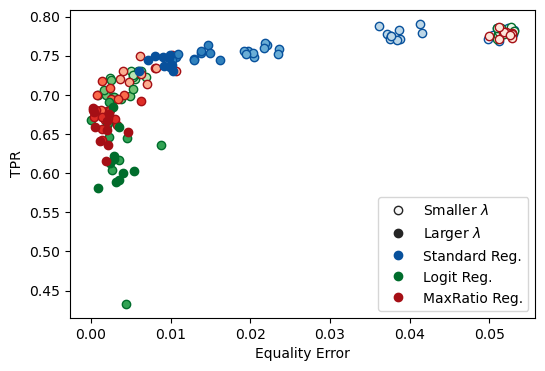

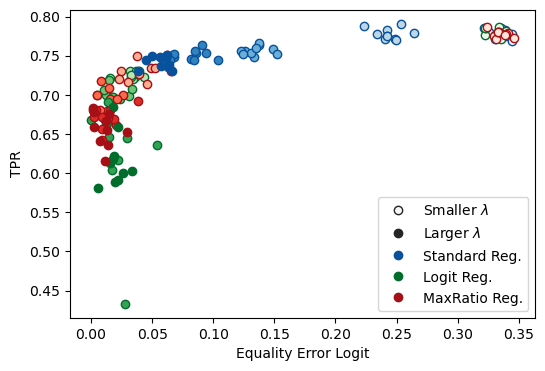

In [57]:
results = torch.load('AUC_init_results.pt')
logit_results = torch.load('AUC_init_logit_results.pt')
maxratio_results = torch.load('AUC_init_maxratio_results.pt')
all_results = {"Standard": results, "Logit": logit_results, "MaxRatio": maxratio_results}
nrep=int(all_results["Standard"]["equal_losses"].shape[1])
lambs = all_results["Standard"]["lambdas"]
alphas = torch.linspace(0.2, 1, len(all_results['Standard']["lambdas"]))
lambda_cols = ["#eff3ff", "#bdd7e7", "#6baed6", "#3182bd", "#08519c"]
lambda_cols_logit = ["#edf8e9", "#bae4b3", "#74c476", "#31a354", "#006d2c"]
lambda_cols_maxratio = ["#fee5d9", "#fcae91", "#fb6a4a", "#de2d26", "#a50f15"]
default_cols = ["#f7f7f7","#cccccc", "#969696", "#636363", "#252525"]
cols = {"Standard": lambda_cols, "Logit": lambda_cols_logit, "MaxRatio": lambda_cols_maxratio}
fig, ax = plt.subplots(figsize=(6,4))
labels = [r"Smaller $\lambda$", r"Larger $\lambda$"]
ax.plot(torch.nan, torch.nan, 'o', label = labels[0], color=default_cols[0],markeredgecolor='#252525')
ax.plot(torch.nan, torch.nan, 'o', label = labels[-1], color=default_cols[-1],markeredgecolor='#252525')
for i,lamb in enumerate(lambs):
    for key in all_results.keys():
        if i == 4:
            label = key+" Reg."
        else:
            label = None
        ax.plot(all_results[key]["equal_losses"][i], all_results[key]["aucs"][i],
                'o', label = label, color=cols[key][i],markeredgecolor=cols[key][-1])
ax.set_xlabel('Equality Error')
ax.set_ylabel('AUC')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(torch.nan, torch.nan, 'o', label = labels[0], color=default_cols[0],markeredgecolor='#252525')
ax.plot(torch.nan, torch.nan, 'o', label = labels[-1], color=default_cols[-1],markeredgecolor='#252525')
for i,lamb in enumerate(lambs):
    for key in all_results.keys():
        if i == 4:
            label = key+" Reg."
        else:
            label = None
        ax.plot(all_results[key]["equal_losses_logit"][i], all_results[key]["aucs"][i],
                'o', label = label, color=cols[key][i],markeredgecolor=cols[key][-1])
ax.set_xlabel('Equality Error Logit')
ax.set_ylabel('AUC')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(torch.nan, torch.nan, 'o', label = labels[0], color=default_cols[0],markeredgecolor='#252525')
ax.plot(torch.nan, torch.nan, 'o', label = labels[-1], color=default_cols[-1],markeredgecolor='#252525')
for i,lamb in enumerate(lambs):
    for key in all_results.keys():
        if i == 4:
            label = key+" Reg."
        else:
            label = None
        ax.plot(all_results[key]["equal_losses"][i], all_results[key]["single_tprs"][i],
                'o', label = label, color=cols[key][i],markeredgecolor=cols[key][-1])   
ax.set_xlabel('Equality Error')
ax.set_ylabel('TPR')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(torch.nan, torch.nan, 'o', label = labels[0], color=default_cols[0],markeredgecolor='#252525')
ax.plot(torch.nan, torch.nan, 'o', label = labels[-1], color=default_cols[-1],markeredgecolor='#252525')
for i,lamb in enumerate(lambs):
    for key in all_results.keys():
        if i == 4:
            label = key+" Reg."
        else:
            label = None
        ax.plot(all_results[key]["equal_losses_logit"][i], all_results[key]["single_tprs"][i],
                'o', label = label, color=cols[key][i],markeredgecolor=cols[key][-1])   
ax.set_xlabel('Equality Error Logit')
ax.set_ylabel('TPR')
ax.legend()

## Prop 1 = 0.01

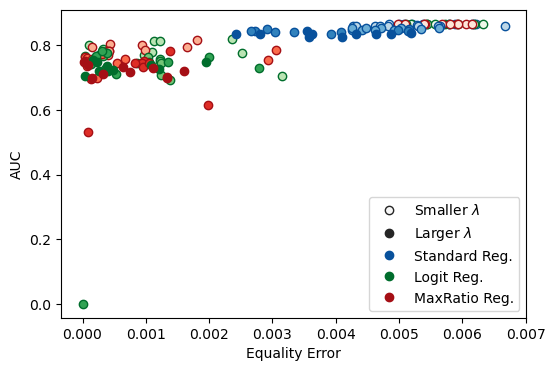

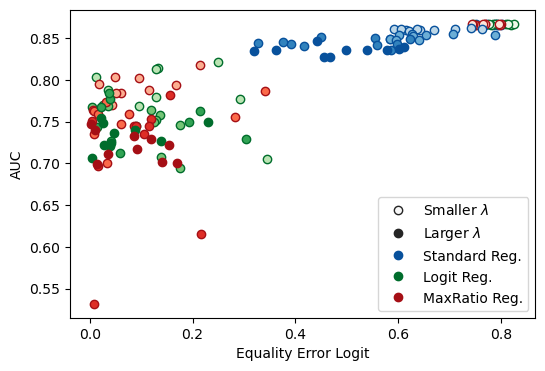

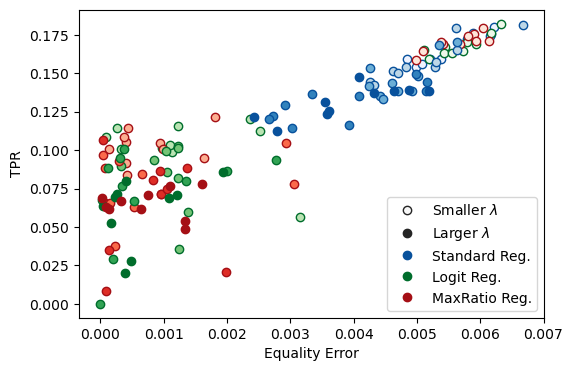

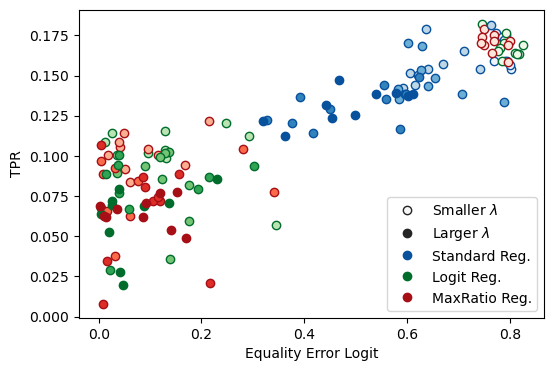

In [56]:
results = torch.load('AUC_prop_results.pt')
logit_results = torch.load('AUC_prop_logit_results.pt')
maxratio_results = torch.load('AUC_prop_maxratio_results.pt')
all_results = {"Standard": results, "Logit": logit_results, "MaxRatio": maxratio_results}
nrep=int(all_results["Standard"]["equal_losses"].shape[1])
lambs = all_results["Standard"]["lambdas"]
alphas = torch.linspace(0.2, 1, len(all_results['Standard']["lambdas"]))
lambda_cols = ["#eff3ff", "#bdd7e7", "#6baed6", "#3182bd", "#08519c"]
lambda_cols_logit = ["#edf8e9", "#bae4b3", "#74c476", "#31a354", "#006d2c"]
lambda_cols_maxratio = ["#fee5d9", "#fcae91", "#fb6a4a", "#de2d26", "#a50f15"]
default_cols = ["#f7f7f7","#cccccc", "#969696", "#636363", "#252525"]
cols = {"Standard": lambda_cols, "Logit": lambda_cols_logit, "MaxRatio": lambda_cols_maxratio}
fig, ax = plt.subplots(figsize=(6,4))
labels = [r"Smaller $\lambda$", r"Larger $\lambda$"]
ax.plot(torch.nan, torch.nan, 'o', label = labels[0], color=default_cols[0],markeredgecolor='#252525')
ax.plot(torch.nan, torch.nan, 'o', label = labels[-1], color=default_cols[-1],markeredgecolor='#252525')
for i,lamb in enumerate(lambs):
    for key in all_results.keys():
        if i == 4:
            label = key+" Reg."
        else:
            label = None
        ax.plot(all_results[key]["equal_losses"][i], all_results[key]["aucs"][i],
                'o', label = label, color=cols[key][i],markeredgecolor=cols[key][-1])
ax.set_xlabel('Equality Error')
ax.set_ylabel('AUC')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(torch.nan, torch.nan, 'o', label = labels[0], color=default_cols[0],markeredgecolor='#252525')
ax.plot(torch.nan, torch.nan, 'o', label = labels[-1], color=default_cols[-1],markeredgecolor='#252525')
for i,lamb in enumerate(lambs):
    for key in all_results.keys():
        if i == 4:
            label = key+" Reg."
        else:
            label = None
        ax.plot(all_results[key]["equal_losses_logit"][i], all_results[key]["aucs"][i],
                'o', label = label, color=cols[key][i],markeredgecolor=cols[key][-1])
ax.set_xlabel('Equality Error Logit')
ax.set_ylabel('AUC')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(torch.nan, torch.nan, 'o', label = labels[0], color=default_cols[0],markeredgecolor='#252525')
ax.plot(torch.nan, torch.nan, 'o', label = labels[-1], color=default_cols[-1],markeredgecolor='#252525')
for i,lamb in enumerate(lambs):
    for key in all_results.keys():
        if i == 4:
            label = key+" Reg."
        else:
            label = None
        ax.plot(all_results[key]["equal_losses"][i], all_results[key]["single_tprs"][i],
                'o', label = label, color=cols[key][i],markeredgecolor=cols[key][-1])   
ax.set_xlabel('Equality Error')
ax.set_ylabel('TPR')
ax.legend()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(torch.nan, torch.nan, 'o', label = labels[0], color=default_cols[0],markeredgecolor='#252525')
ax.plot(torch.nan, torch.nan, 'o', label = labels[-1], color=default_cols[-1],markeredgecolor='#252525')
for i,lamb in enumerate(lambs):
    for key in all_results.keys():
        if i == 4:
            label = key+" Reg."
        else:
            label = None
        ax.plot(all_results[key]["equal_losses_logit"][i], all_results[key]["single_tprs"][i],
                'o', label = label, color=cols[key][i],markeredgecolor=cols[key][-1])   
ax.set_xlabel('Equality Error Logit')
ax.set_ylabel('TPR')
ax.legend()

# Further Questions:
* Do we work with fairness for just 1 $\tau$ value or across all (like auc)?
* Do we use a different closeness metric for fairness than absolute erro in the probabilties?
* For multiple groups, do we take all combinations or regularise each separately?